# Building a Credit Scorecard to offer Credit Cards to students
- Data Preparation
- Correlation Analysis
- Fine Classing
- Coarse Classing
- WOE Binning and Encoding
- Creating a Credit Scorecard

##Step 1: Import relevant libraries

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


##Step 2: Read in data files - Application data, Bureau data

In [2]:
# import csv files
bureau_data = pd.read_csv("IS453 Group Assignment - Bureau Data.csv")
app_data = pd.read_csv("IS453 Group Assignment - Application Data.csv")
bureau_data.info

<bound method DataFrame.info of          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

       

##Step 3a: Data Preparation for Bureau Data

###1. Filter to keep only relevant credit_type
Keep only credit types that may be relevant to target customer segment - students, 'Credit card', 'Microloan', 'Consumer credit', 'Cash loan (non-earmarked)'

In [3]:
# Start of data preparation for bureau data
#Step 1: Filter to keep only CREDIT_TYPE = "credit card", "Microloan", "Consumer credit" & "Cash loan (non-earmarked)"
df_filtered = bureau_data[bureau_data['CREDIT_TYPE'].isin(['Credit card', 'Microloan', 'Consumer credit', 'Cash loan (non-earmarked)'])]
df_filtered = df_filtered.copy()
#Create 4 new columns and categorise as a binary
df_filtered['IS_CREDIT_CARD'] = df_filtered['CREDIT_TYPE'] == 'Credit card'
df_filtered['IS_MICROLOAN'] = df_filtered['CREDIT_TYPE'] == 'Microloan'
df_filtered['IS_CONSUMER_CREDIT'] = df_filtered['CREDIT_TYPE'] == 'Consumer credit'
df_filtered['IS_CASH_LOAN'] = df_filtered['CREDIT_TYPE'] == 'Cash loan (non-earmarked)'
#Create 4 new columns and sum by SK_ID_CURR (each row with same SK_ID_CURR will have same values in these columns)
numtypecard= df_filtered.groupby('SK_ID_CURR').agg(
    NUM_CREDIT_CARD=('IS_CREDIT_CARD','sum'),
    NUM_MICROLOAN=('IS_MICROLOAN','sum'),
    NUM_CONSUMER_CREDIT=('IS_CONSUMER_CREDIT','sum'),
    NUM_CASH_LOAN=('IS_CASH_LOAN','sum')
).reset_index()
df_filtered = df_filtered.merge(numtypecard, on='SK_ID_CURR', how='left')
#Drop the 4 IS_CARD columns
df_filtered = df_filtered.drop(columns=['IS_CREDIT_CARD','IS_MICROLOAN','IS_CONSUMER_CREDIT','IS_CASH_LOAN'])
#df_filtered.to_csv('filecheck1.csv', index=False) #just to check



###2. Filter to keep only one currency
Currency 1 is 99.9+% of bureau data, so keep only currency 1

In [4]:
#Step 2: Filter to keep only CREDIT_CURRENCY = 'currency 1'
df_filtered = df_filtered[df_filtered['CREDIT_CURRENCY'] == 'currency 1']
#Step 3: Drop entire CREDIT_CURRENCY column
df_filtered = df_filtered.drop('CREDIT_CURRENCY', axis=1)

###3. Drop the CREDIT_CURRENCY column
since there is only one currency left

In [5]:
# Save the filtered dataset (optional)
#df_filtered.to_csv('filtered_data_4.csv', index=False)

# Display the first few rows
print(df_filtered.info)

<bound method DataFrame.info of          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE  DAYS_CREDIT  \
0            215354       5714462        Closed         -497   
1            215354       5714463        Active         -208   
2            215354       5714464        Active         -203   
3            215354       5714465        Active         -203   
4            215354       5714466        Active         -629   
...             ...           ...           ...          ...   
1666274      259355       5057750        Active          -44   
1666275      100044       5057754        Closed        -2648   
1666276      100044       5057762        Closed        -1809   
1666277      246829       5057770        Closed        -1878   
1666278      246829       5057778        Closed         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0         

###4. Drop the annuity column

In [6]:
#Step 4: Drop annuity column
df_filtered = df_filtered.drop('AMT_ANNUITY', axis=1)

###5. From CREDIT_DAY_OVERDUE, create 2 new columns AVG_OVERDUE_DAYS, OVERDUE_RATIO

In [7]:
#Step 5: Combine rows for CREDIT_DAY_OVERDUE column
credit_card_summary = df_filtered.groupby('SK_ID_CURR').agg(
    TOTAL_CREDIT_CARDS=('CREDIT_TYPE', 'count'),
    OVERDUE_CREDIT_CARDS=('CREDIT_DAY_OVERDUE', lambda x: (x > 0).sum()),  # Count overdue credit cards
    TOTAL_OVERDUE_DAYS=('CREDIT_DAY_OVERDUE', 'sum')  # Sum of overdue days
).reset_index()
# Create 2 new columns: OVERDUE_RATIO and AVG_OVERDUE_DAYS
credit_card_summary['OVERDUE_RATIO'] = credit_card_summary['OVERDUE_CREDIT_CARDS'] / credit_card_summary['TOTAL_CREDIT_CARDS']
credit_card_summary['AVG_OVERDUE_DAYS'] = credit_card_summary['TOTAL_OVERDUE_DAYS'] / credit_card_summary['OVERDUE_CREDIT_CARDS']
credit_card_summary['AVG_OVERDUE_DAYS'] = credit_card_summary['AVG_OVERDUE_DAYS'].fillna(0)  # Handle NaN when no overdue
df_filtered = df_filtered.merge(credit_card_summary, on='SK_ID_CURR', how='left')
#drop credit_day_overdue column, and all intermediate columns once done
df_filtered = df_filtered.drop(columns=['CREDIT_TYPE','TOTAL_CREDIT_CARDS','OVERDUE_CREDIT_CARDS','TOTAL_OVERDUE_DAYS','CREDIT_DAY_OVERDUE'])



###6. Fill missing values in 'AMT_CREDIT_MAX_OVERDUE' with the max value from 'AMT_CREDIT_SUM_OVERDUE'

In [8]:
#Step 6 Fill missing values in 'AMT_CREDIT_MAX_OVERDUE' with the max value from 'AMT_CREDIT_SUM_OVERDUE'
max_overdue = df_filtered.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].transform('max')
df_filtered['AMT_CREDIT_MAX_OVERDUE'] = df_filtered['AMT_CREDIT_MAX_OVERDUE'].fillna(max_overdue)
df_filtered['AMT_CREDIT_SUM_OVERDUE'] = df_filtered.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].transform('sum')
df_filtered['AMT_CREDIT_MAX_OVERDUE'] = df_filtered.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].transform('max')
#df_filtered.to_csv('filename.csv', index=False) #to check columns in excel

###7. From AMT_CREDIT_SUM_DEBT and AMT_CREDIT_SUM, create new column AVG_CREDIT_RATIO


*   Combine AMT_CREDIT_SUM and AMT_CREDIT_SUM_DEBT to form CREDIT_DEBT_RATIO("percentage of loan debt unpaid"), then drop AMT_CREDIT_SUM and AMT_CREDIT_SUM_DEBT
*   Calculate the average of CREDIT_DEBT_RATIO for each SK_ID_CURR, forming AVG_CRED_DEBT_RATIO
*   Count the number of NaN values in CREDIT_DEBT_RATIO for each SK_ID_CURR to form NaN_COUNT_CRED_DEBT_RATIO

In [9]:
#Step 7 Combine AMT_CREDIT_SUM and AMT_CREDIT_SUM_DEBT to get percentage of loan debt unpaid
df_filtered['CREDIT_DEBT_RATIO'] = np.where(
    df_filtered['AMT_CREDIT_SUM'] == 0,
    np.nan,
    df_filtered['AMT_CREDIT_SUM_DEBT'] / df_filtered['AMT_CREDIT_SUM']
)
df_filtered = df_filtered.drop(columns='AMT_CREDIT_SUM_DEBT')
df_filtered = df_filtered.drop(columns='AMT_CREDIT_SUM')

#Calculate the average of CREDIT_DEBT_RATIO for each SK_ID_CURR
avg_debt_ratio = df_filtered.groupby('SK_ID_CURR')['CREDIT_DEBT_RATIO'].apply(lambda x: x[~x.isna()].mean()).reset_index()
avg_debt_ratio.rename(columns={'CREDIT_DEBT_RATIO': 'AVG_CRED_DEBT_RATIO'}, inplace=True)
avg_debt_ratio['AVG_CRED_DEBT_RATIO']=avg_debt_ratio['AVG_CRED_DEBT_RATIO'].fillna('Missing')

#Count the number of NaN values in CREDIT_DEBT_RATIO for each SK_ID_CURR
nan_count = df_filtered.groupby('SK_ID_CURR')['CREDIT_DEBT_RATIO'].apply(lambda x: x.isna().sum()).reset_index()
nan_count.rename(columns={'CREDIT_DEBT_RATIO': 'NaN_COUNT_CRED_DEBT_RATIO'}, inplace=True)

#Merge the results back into the original dataframe
df_filtered = df_filtered.merge(avg_debt_ratio[['SK_ID_CURR', 'AVG_CRED_DEBT_RATIO']], on='SK_ID_CURR', how='left')
df_filtered = df_filtered.merge(nan_count[['SK_ID_CURR', 'NaN_COUNT_CRED_DEBT_RATIO']], on='SK_ID_CURR', how='left')
#df_filtered.to_csv('filename.csv', index=False) #to check columns in excel
# drop credit_debt_ratio
df_filtered = df_filtered.drop(columns="CREDIT_DEBT_RATIO")


###8. Apply One-hot encoding on CREDIT_ACTIVE, forming 4 new columns NUMACTIVE, NUMCLOSED, NUMSOLD, NUMBADDEBT

In [10]:
#Step 8 Credit active column split into 4 for one-hot encoding
# One-hot encoding for CREDIT_ACTIVE with numerical values (1 and 0)
df_filtered = pd.get_dummies(df_filtered, columns=['CREDIT_ACTIVE'], prefix='CREDIT_ACTIVE', dtype=int)

# Rename columns based on the CREDIT_ACTIVE categories
df_filtered.rename(columns={
    'CREDIT_ACTIVE_Active': 'NUMACTIVE',
    'CREDIT_ACTIVE_Closed': 'NUMCLOSED',
    'CREDIT_ACTIVE_Sold': 'NUMSOLD',
    'CREDIT_ACTIVE_Bad debt': 'NUMBADDEBT'
}, inplace=True)

# Group by SK_ID_CURR and sum the new numeric columns
df_summed = df_filtered.groupby('SK_ID_CURR')[['NUMACTIVE', 'NUMCLOSED', 'NUMSOLD', 'NUMBADDEBT']].transform('sum')

# Update df_filtered to reflect the summed values across SK_ID_CURR
df_filtered.update(df_summed)

# Print result to verify
print(df_filtered.head())

   SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  DAYS_CREDIT_ENDDATE  \
0      215354       5714462         -497               -153.0   
1      215354       5714463         -208               1075.0   
2      215354       5714464         -203                528.0   
3      215354       5714465         -203                  NaN   
4      215354       5714466         -629               1197.0   

   DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0             -153.0                 77674.5                   0   
1                NaN                 77674.5                   0   
2                NaN                 77674.5                   0   
3                NaN                 77674.5                   0   
4                NaN                 77674.5                   0   

   AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  ...  \
0                   NaN                     0.0                -131  ...   
1                   NaN                     0.0 

###9. From DAYS_CREDIT, form new column AVG_FREQ_CRED_APP

In [11]:
#Step 9 DAYS_CREDIT becomes a new column called AVG_FREQ_CRED_APP
df_filtered['AVG_FREQ_CRED_APP'] = df_filtered.groupby('SK_ID_CURR')['DAYS_CREDIT'].transform('mean')
df_filtered = df_filtered.drop('DAYS_CREDIT', axis=1)

###10. Drop other irrelevant columns DAYS_CREDIT_UPDATE, SK_ID_BUREAU, DAYS_CREDIT_ENDDATE, AMT_CREDIT_SUM_LIMIT, DAYS_ENDDATE_FACT, CNT_CREDIT_PROLONG

In [12]:
#Step 10 Drop all columns not used
df_filtered = df_filtered.drop(columns=['DAYS_CREDIT_UPDATE','SK_ID_BUREAU','DAYS_CREDIT_ENDDATE','AMT_CREDIT_SUM_LIMIT','DAYS_ENDDATE_FACT','CNT_CREDIT_PROLONG'])

###11. Combine rows by SK_ID_CURR, such that each row has unique SK_ID_CURR

In [13]:
#Step 11 Combine rows by unique SK_ID_CURR
df_filtered = df_filtered.drop_duplicates(subset=['SK_ID_CURR'], keep='first')
df_filtered['AVG_CRED_DEBT_RATIO'] = df_filtered['AVG_CRED_DEBT_RATIO'].replace(-np.inf, "Missing")
df_filtered.to_csv("cleanedbureau.csv",index=False)

##Step 3b: Data Preparation for Application Data

###1. Remove all rows where age >= 26
Only <26 years old are considered students.

In [14]:
#Step 1: Keep all rows where -6570 > days_birth > -9490
# Filter for students (18 < aged < 26yrs old) only
app_data_students = app_data[(app_data["DAYS_BIRTH"] > -9490) & (app_data["DAYS_BIRTH"] < -6570)]
app_data_students.to_csv('app_data_students.csv', index=False)

###2a. Drop irrelevant columns
'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'DAYS_REGISTRATION','REGION_RATING_CLIENT', 'OWN_CAR_AGE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG','APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE','LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'FLOORSMIN_AVG', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'APARTMENTS_MEDI','LIVINGAPARTMENTS_MEDI', 'COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI'

###2b. Drop rows with OCCUPATION_TYPE == Managers, Core staff, High skill tech staff, Realty agents

In [15]:
#Step 2: Drop unneccessary columns
app_data_students = app_data_students.drop(columns=['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'DAYS_REGISTRATION','REGION_RATING_CLIENT', 'OWN_CAR_AGE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG','APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE','LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'FLOORSMIN_AVG', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'APARTMENTS_MEDI','LIVINGAPARTMENTS_MEDI', 'COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI'], axis=1, inplace=False)
app_data_students = app_data_students[app_data_students['OCCUPATION_TYPE'] != 'Managers']
app_data_students = app_data_students[app_data_students['OCCUPATION_TYPE'] != 'Core staff']
app_data_students = app_data_students[app_data_students['OCCUPATION_TYPE'] != 'High skill tech staff']
app_data_students = app_data_students[app_data_students['OCCUPATION_TYPE'] != 'Realty agents']
#Percentage distribution of categories within a column after you've filtered or cleaned your data
app_data_students['OCCUPATION_TYPE'].value_counts(normalize=True) * 100

print(app_data_students.columns)

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_

##Step 4: Merge Application data with Bureau data and continue data prepation

In [16]:
#Merge bureau data with application data (left join to application)
df_merged = app_data_students.merge(df_filtered, on="SK_ID_CURR", how="left")

In [17]:
#Check that data merged successfully
df_merged.to_csv('mergeddata2.csv',index=False)

###4. Convert Categorical variables to numerical variables

*    Apply Label Encoding for "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "ORGANIZATION_TYPE", "OCCUPATION_TYPE"
*    Convert Y/N for FLAG_OWN_REALTY to 0/1
*    Convert negative values to positive for easier processing

In [18]:
#Continue Data preparation for merged dataset
# import csv files
merged_data = pd.read_csv("mergeddata.csv")

# # Columns to one-hot encode
# categorical_cols = [
#     "NAME_INCOME_TYPE",
#     "NAME_EDUCATION_TYPE",
#     "NAME_FAMILY_STATUS",
#     "NAME_HOUSING_TYPE",
#     "ORGANIZATION_TYPE",
#     "OCCUPATION_TYPE"
# ]

# # One-hot encoding using get_dummies
# df_encoded = pd.get_dummies(merged_data, columns=categorical_cols, drop_first=False)

mapped_df = merged_data.copy()
# map Y/N for FLAG_OWN_REALTY to 1/0
mapped_df['FLAG_OWN_REALTY'] = mapped_df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

# apply absolute value (remove negative signs and converting to positive number)
mapped_df[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'AVG_FREQ_CRED_APP']] = mapped_df[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'AVG_FREQ_CRED_APP']].abs()
mapped_df.to_csv('mapped_data.csv',index=False)


##Step 5: Correlation Analysis
and get the top 30 variables with highest correlation to TARGET

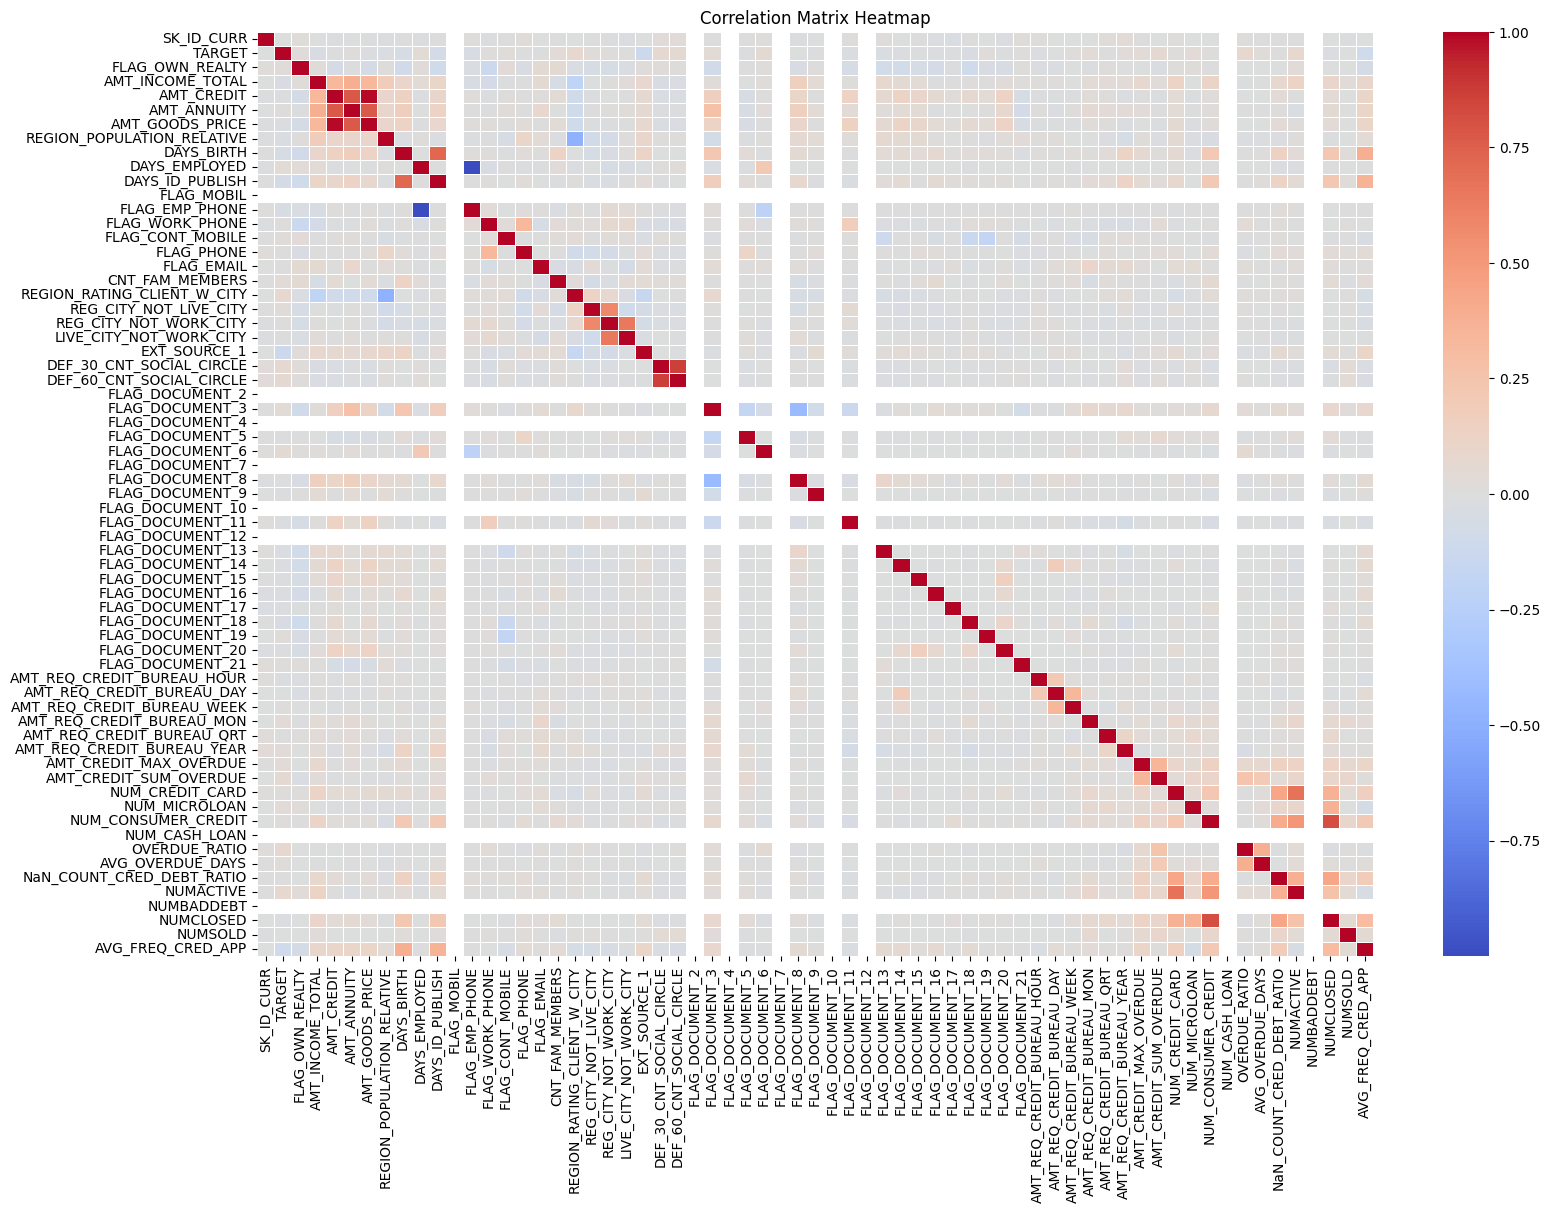

TARGET                         1.000000
EXT_SOURCE_1                   0.118081
AVG_FREQ_CRED_APP              0.098444
REGION_RATING_CLIENT_W_CITY    0.076147
OVERDUE_RATIO                  0.074837
NUMACTIVE                      0.070998
DAYS_ID_PUBLISH                0.067857
DEF_30_CNT_SOCIAL_CIRCLE       0.063906
DEF_60_CNT_SOCIAL_CIRCLE       0.060440
AMT_CREDIT_SUM_OVERDUE         0.057235
FLAG_DOCUMENT_6                0.049508
DAYS_BIRTH                     0.047216
FLAG_DOCUMENT_3                0.045032
FLAG_EMP_PHONE                 0.042899
DAYS_EMPLOYED                  0.042056
AMT_CREDIT_MAX_OVERDUE         0.038058
AMT_REQ_CREDIT_BUREAU_MON      0.036805
FLAG_DOCUMENT_18               0.035375
CNT_FAM_MEMBERS                0.034073
NUM_MICROLOAN                  0.032263
AMT_INCOME_TOTAL               0.031280
FLAG_DOCUMENT_13               0.029277
REGION_POPULATION_RELATIVE     0.027760
AMT_REQ_CREDIT_BUREAU_YEAR     0.026589
FLAG_OWN_REALTY                0.023931


In [19]:
#for encoded data (Get top 30 correlations)
mapped_data = pd.read_csv("mapped_data.csv")

corr_df = mapped_data.copy()
corr_df = corr_df.drop(["NAME_INCOME_TYPE",
     "NAME_EDUCATION_TYPE",
     "NAME_FAMILY_STATUS",
     "NAME_HOUSING_TYPE",
     "ORGANIZATION_TYPE",
     "OCCUPATION_TYPE"], axis=1)
#corr_df.columns

noNA_encoded_data = corr_df.dropna()

noNA_encoded_data = noNA_encoded_data[noNA_encoded_data.ne("Missing").all(axis=1)]

# Only keep numeric columns before computing correlation
numeric_data = noNA_encoded_data.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
# Add title
plt.title("Correlation Matrix Heatmap")
plt.show()

#getting top 30
correlations = numeric_data.corr()["TARGET"]  # Drop NaN values (if any)

# Sort correlations in descending order (absolute value for strongest relationships)
top_30_corr = correlations.abs().sort_values(ascending=False).head(31)
print(top_30_corr)

##Step 6. Calculate WOE and IV, do Fine Classing for the 30 variables

IV for EXT_SOURCE_1 with 21 bins: 0.1573


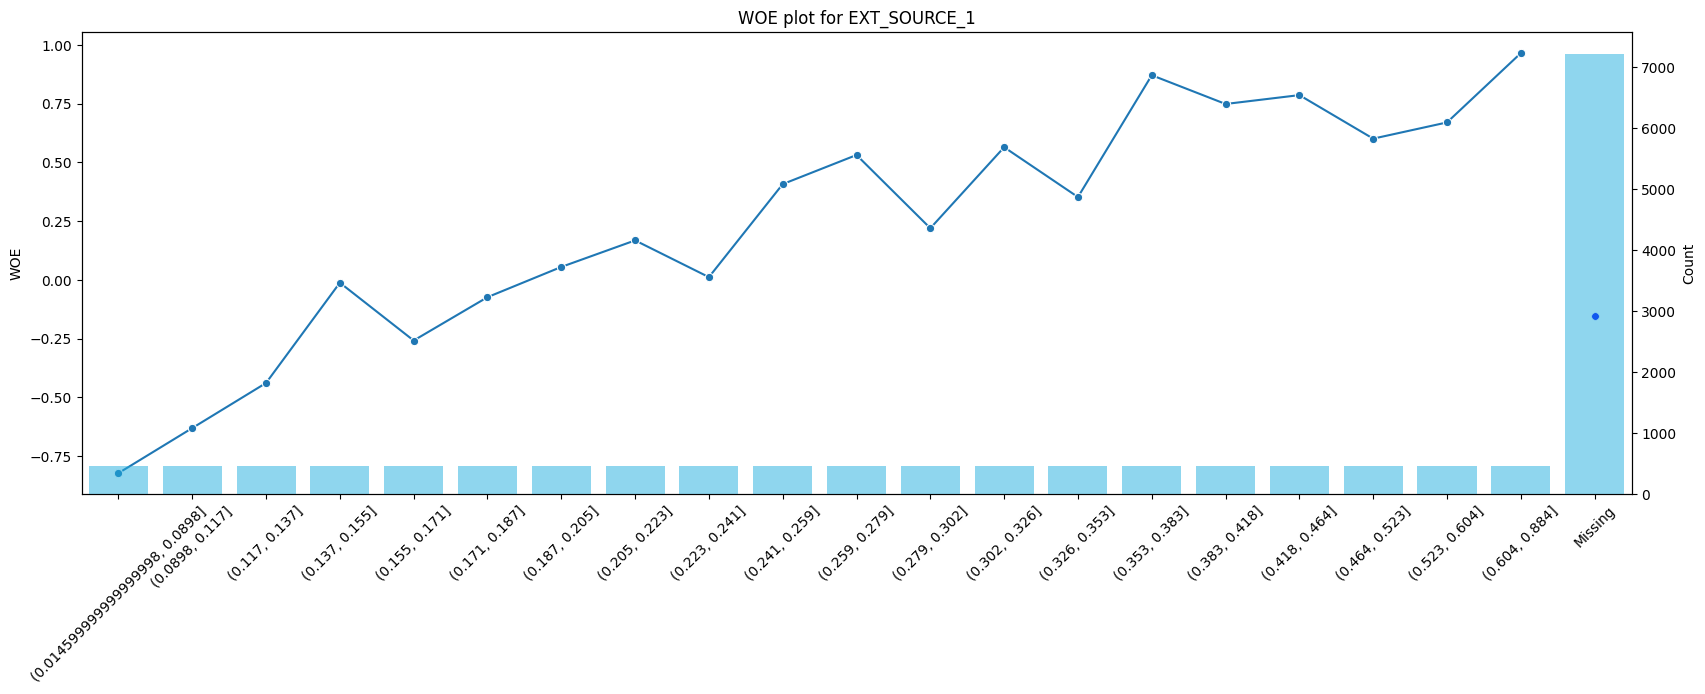

EXT_SOURCE_1 successfully loaded
IV for AVG_FREQ_CRED_APP with 21 bins: 0.0693


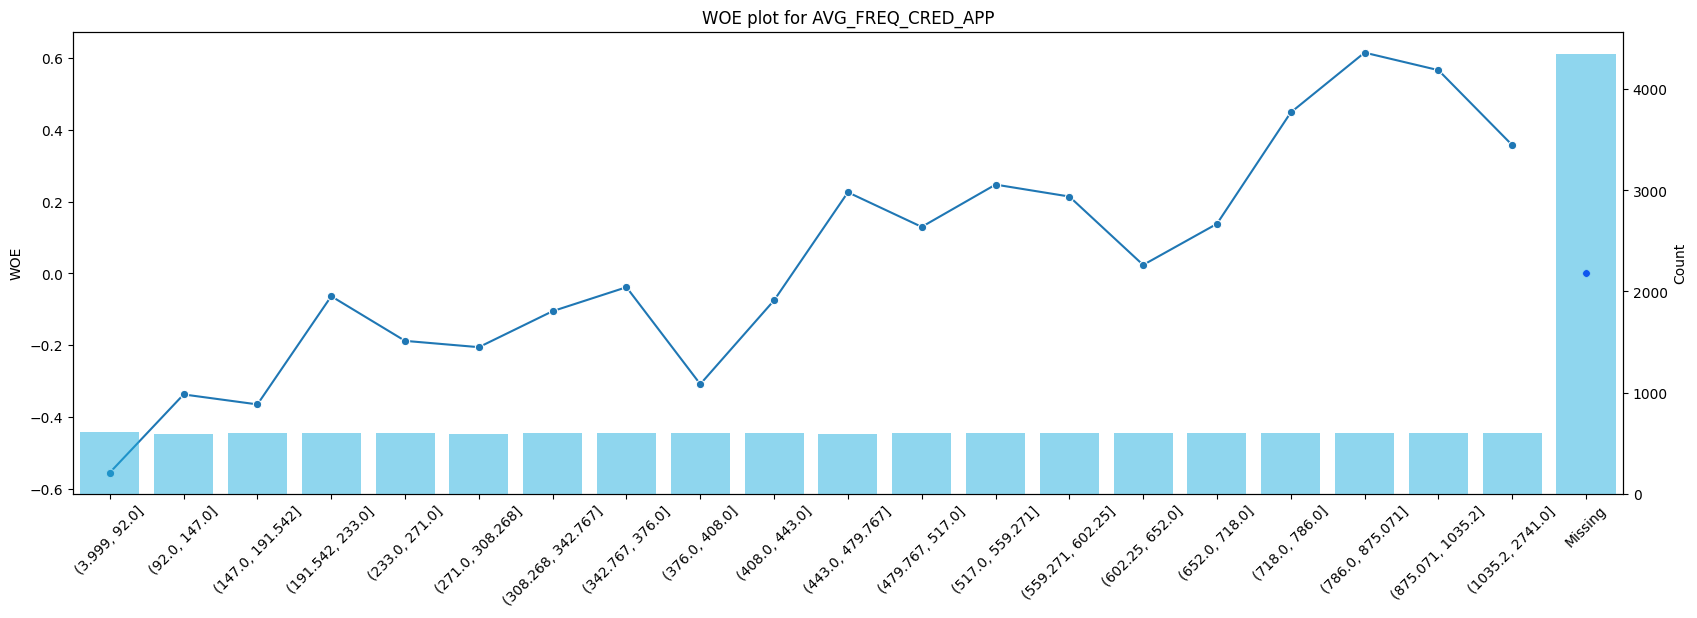

AVG_FREQ_CRED_APP successfully loaded
IV for REGION_RATING_CLIENT_W_CITY with 2 bins: 0.0368


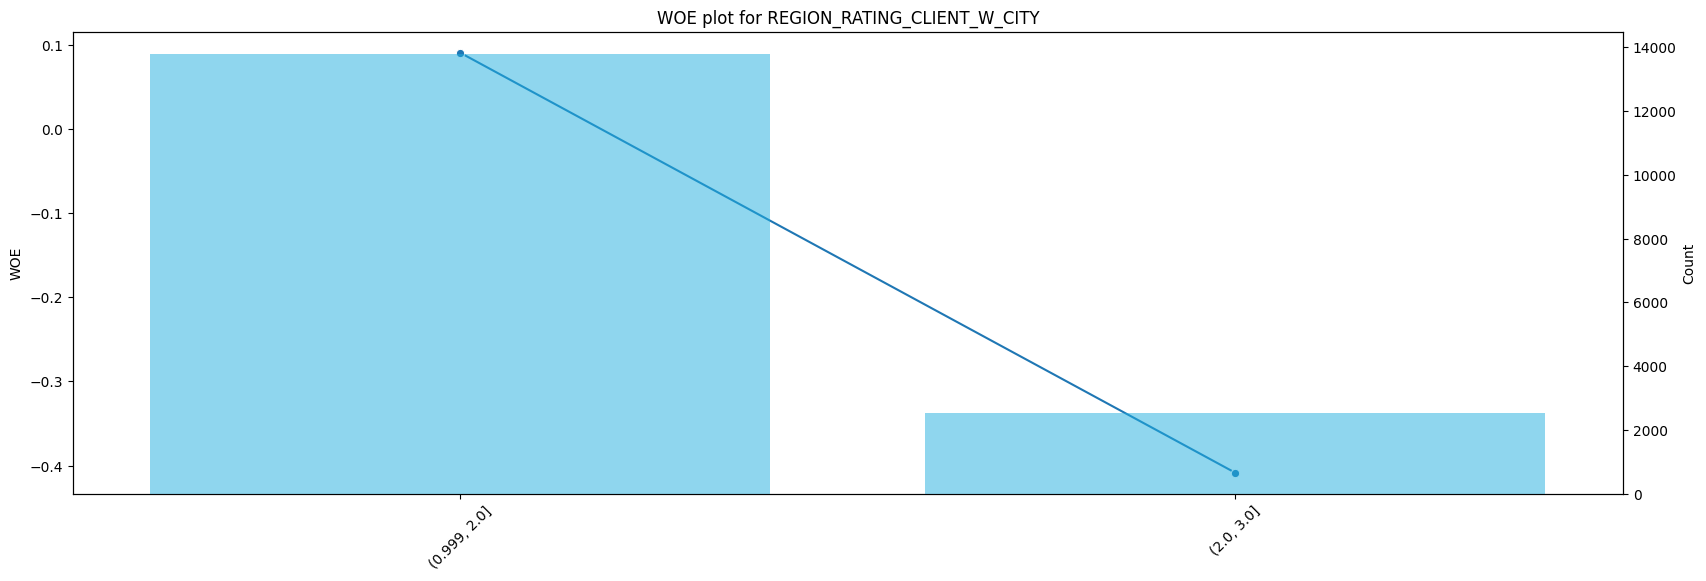

REGION_RATING_CLIENT_W_CITY successfully loaded
IV for OVERDUE_RATIO with 2 bins: 0.0


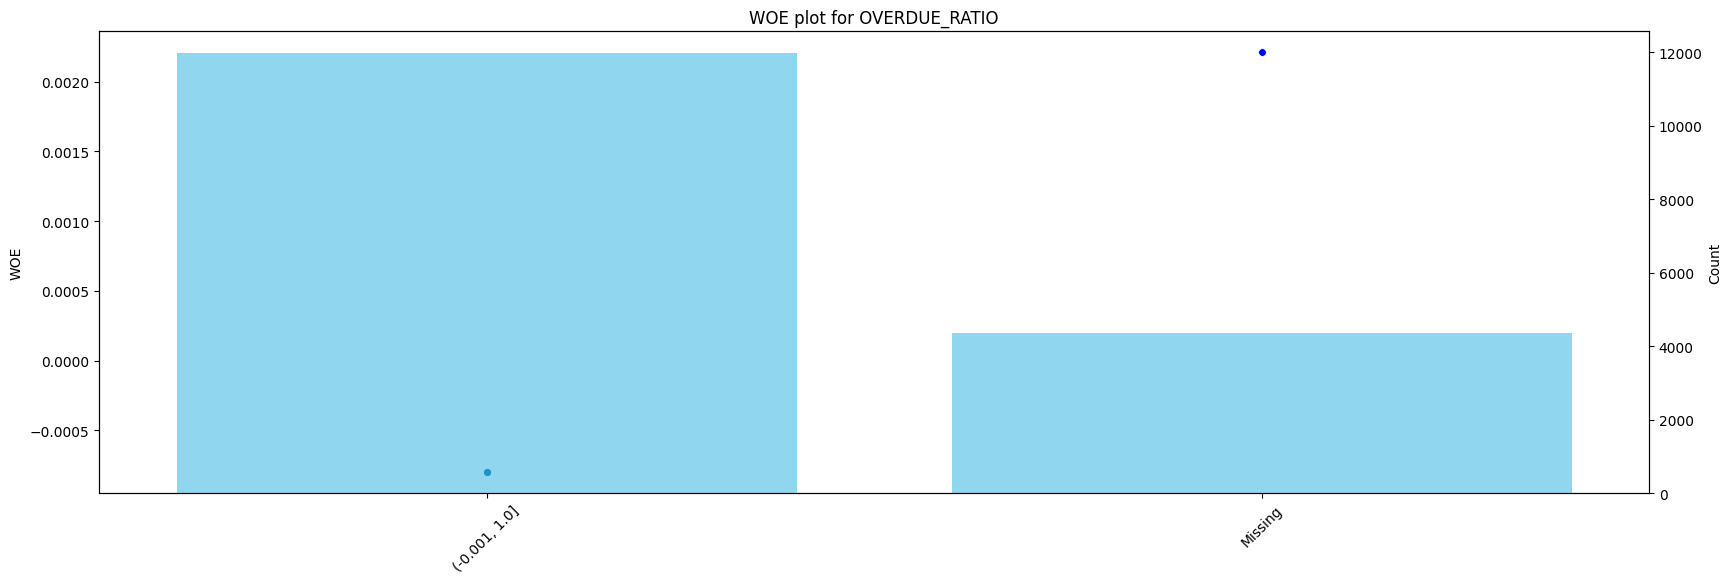

OVERDUE_RATIO successfully loaded
IV for NUMACTIVE with 6 bins: 0.0323


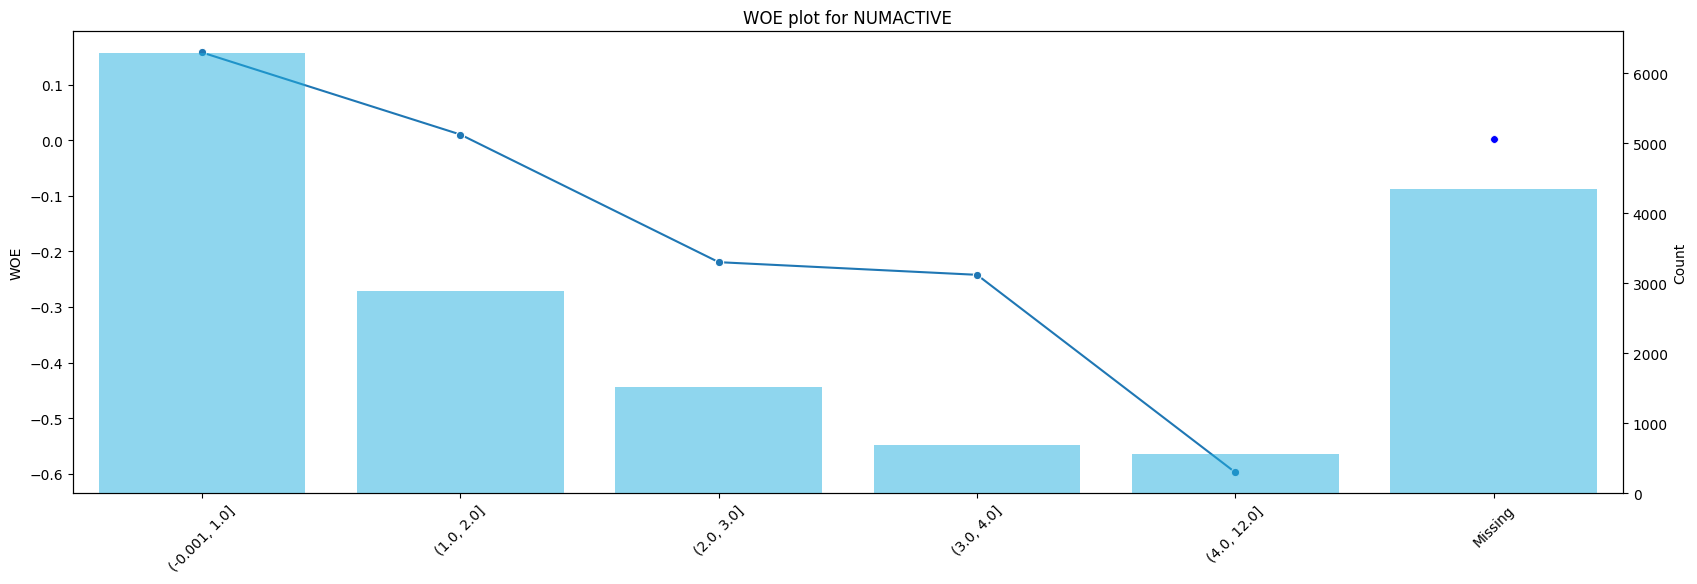

NUMACTIVE successfully loaded
IV for DAYS_ID_PUBLISH with 20 bins: 0.039


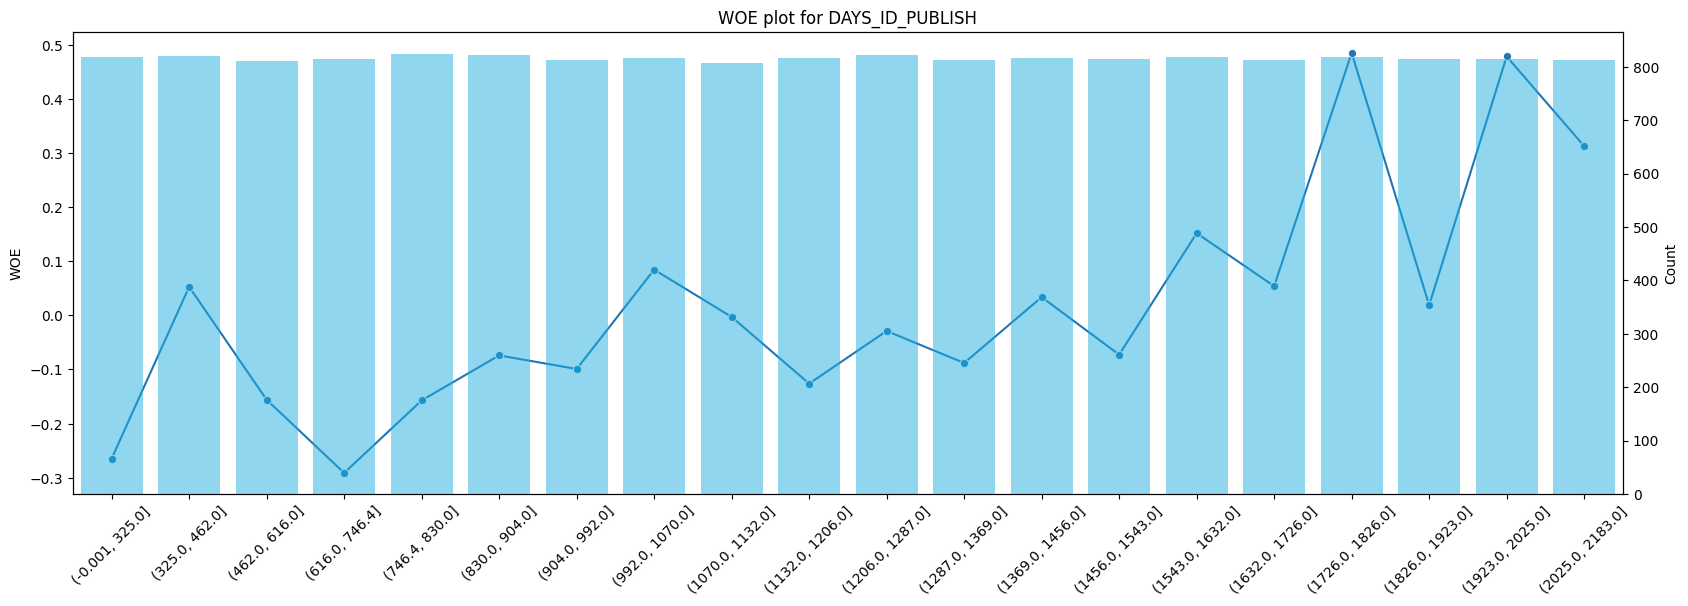

DAYS_ID_PUBLISH successfully loaded
IV for DEF_30_CNT_SOCIAL_CIRCLE with 3 bins: 0.0058


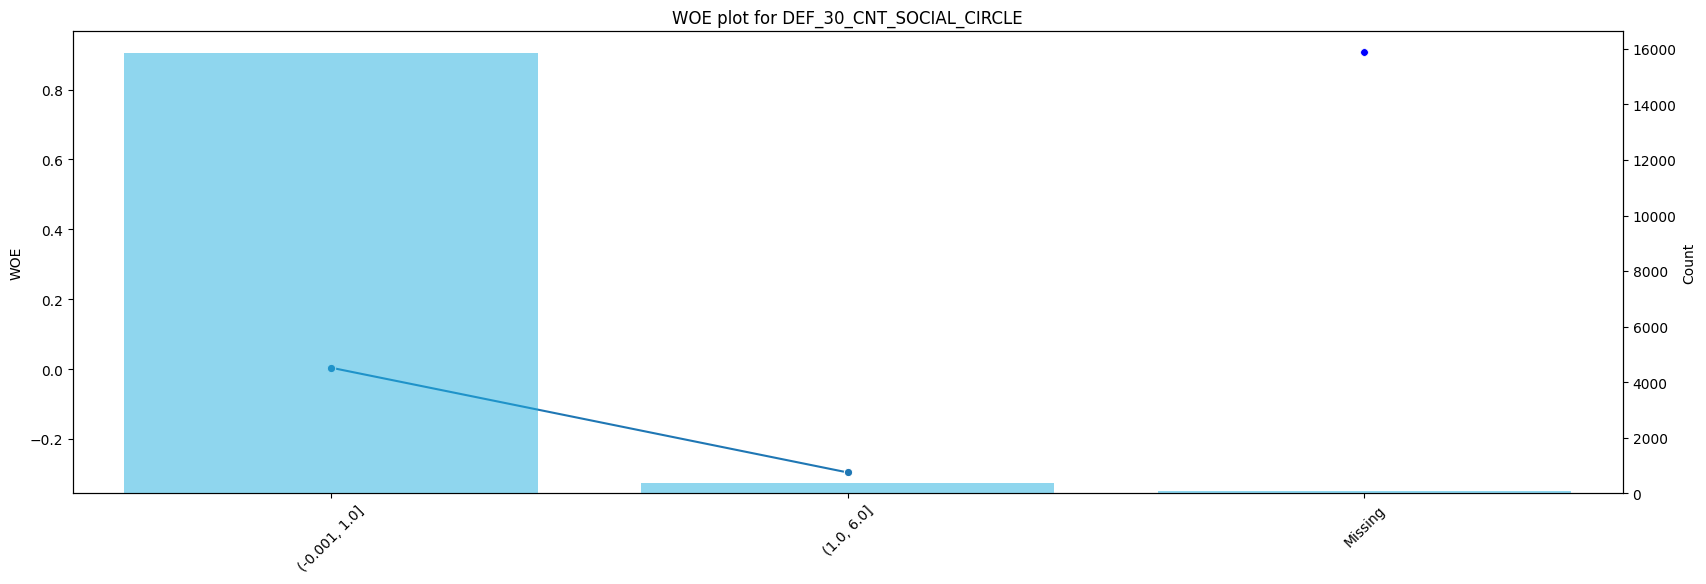

DEF_30_CNT_SOCIAL_CIRCLE successfully loaded
IV for DEF_60_CNT_SOCIAL_CIRCLE with 3 bins: 0.0057


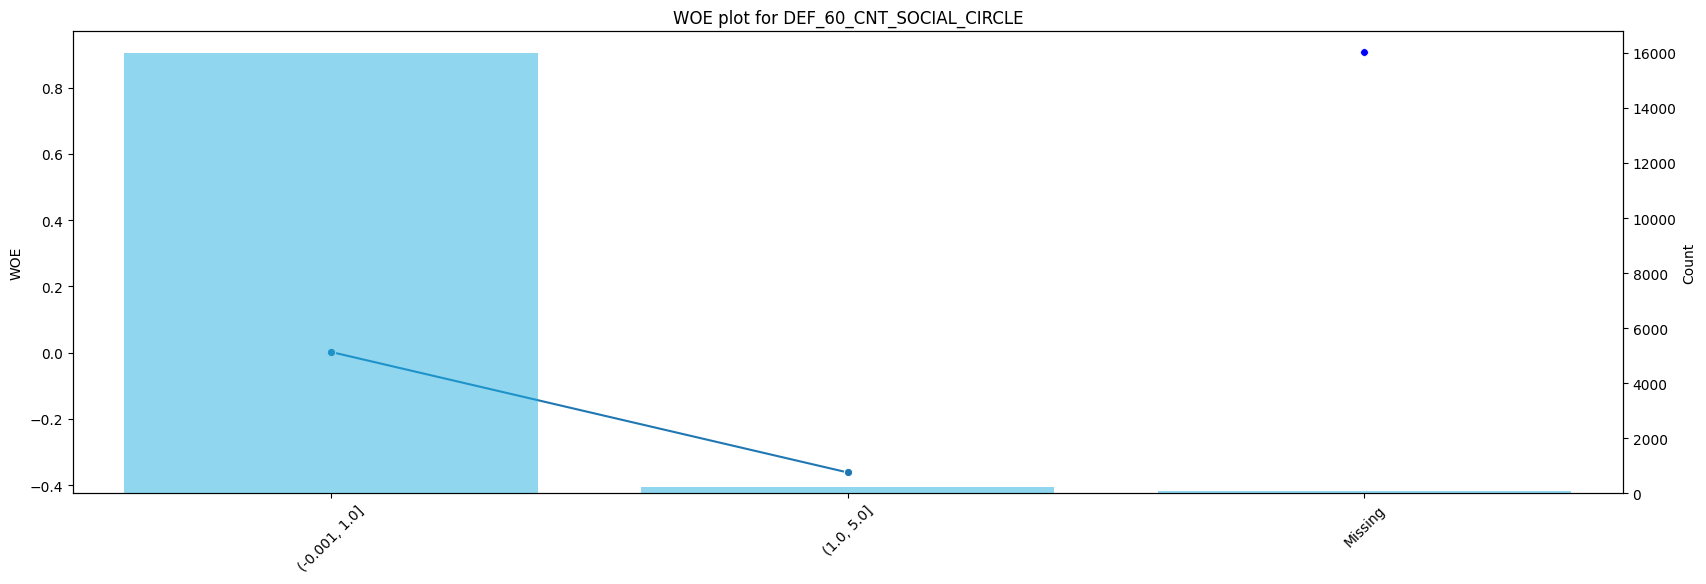

DEF_60_CNT_SOCIAL_CIRCLE successfully loaded
IV for AMT_CREDIT_SUM_OVERDUE with 2 bins: 0.0


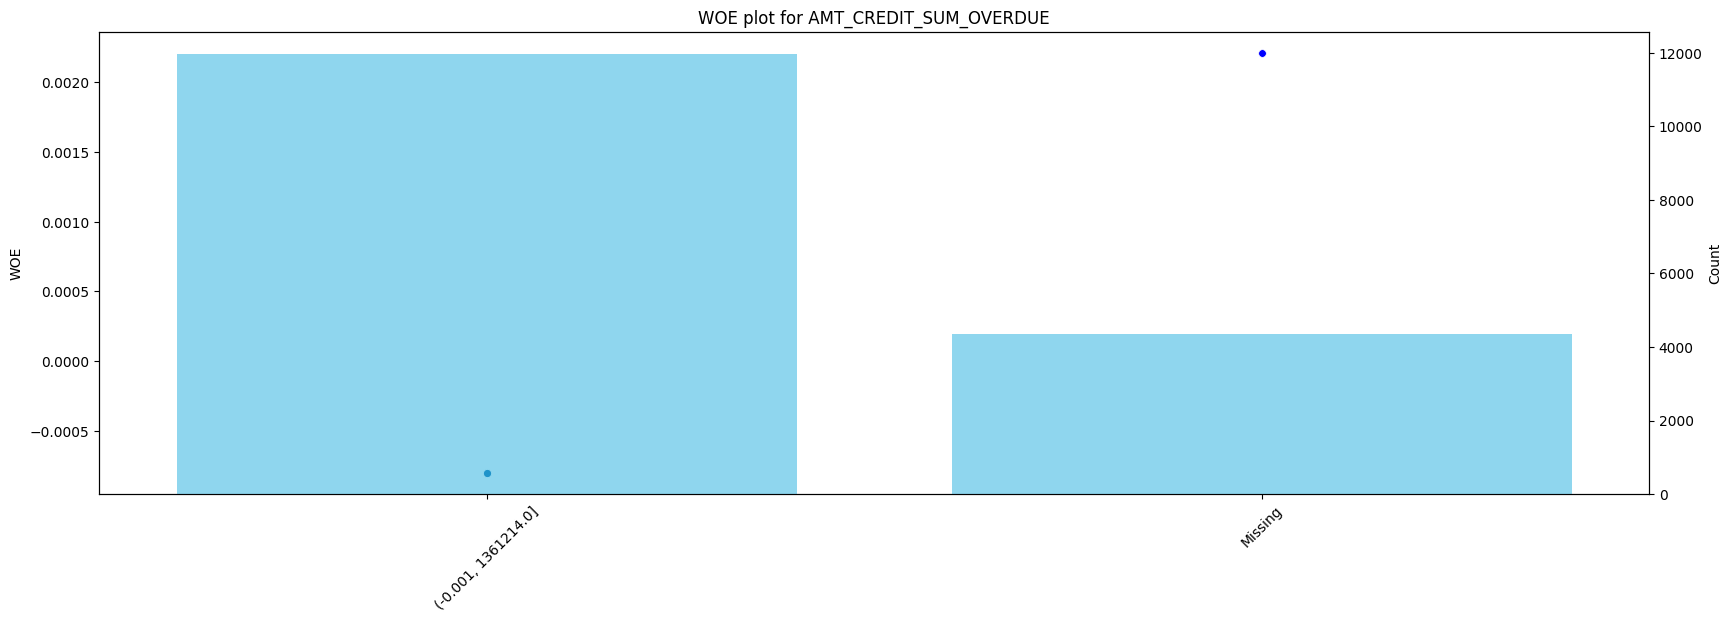

AMT_CREDIT_SUM_OVERDUE successfully loaded
IV for FLAG_DOCUMENT_6 with 1 bins: 0.0


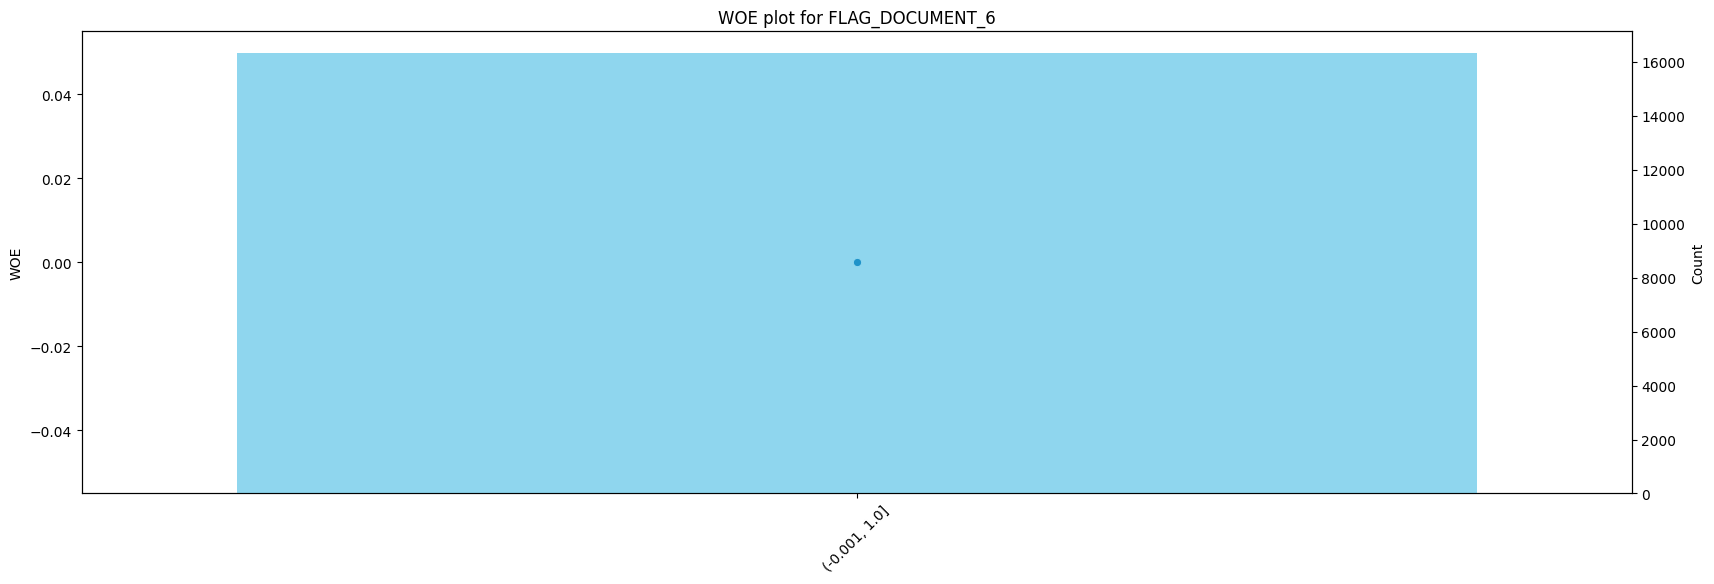

FLAG_DOCUMENT_6 successfully loaded
IV for DAYS_BIRTH with 20 bins: 0.03


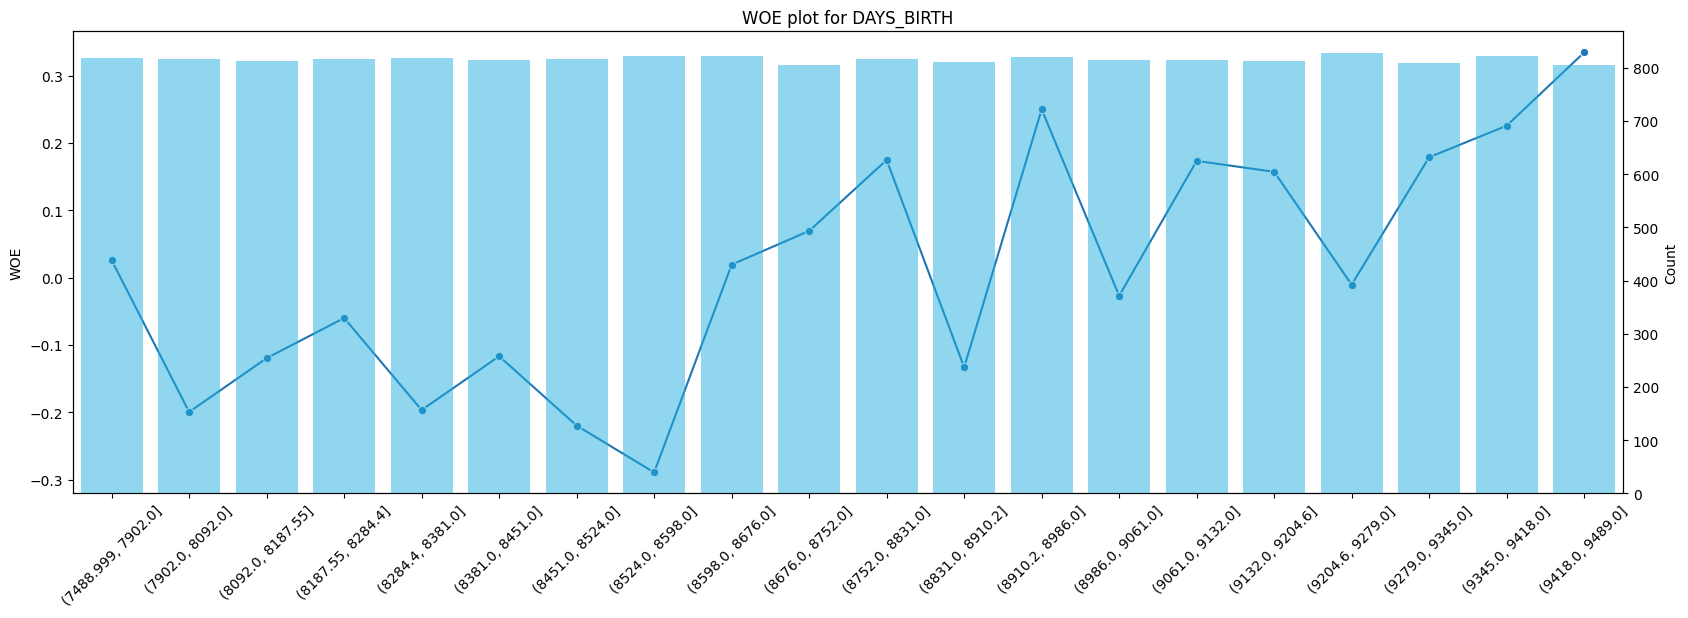

DAYS_BIRTH successfully loaded
IV for FLAG_DOCUMENT_3 with 1 bins: 0.0


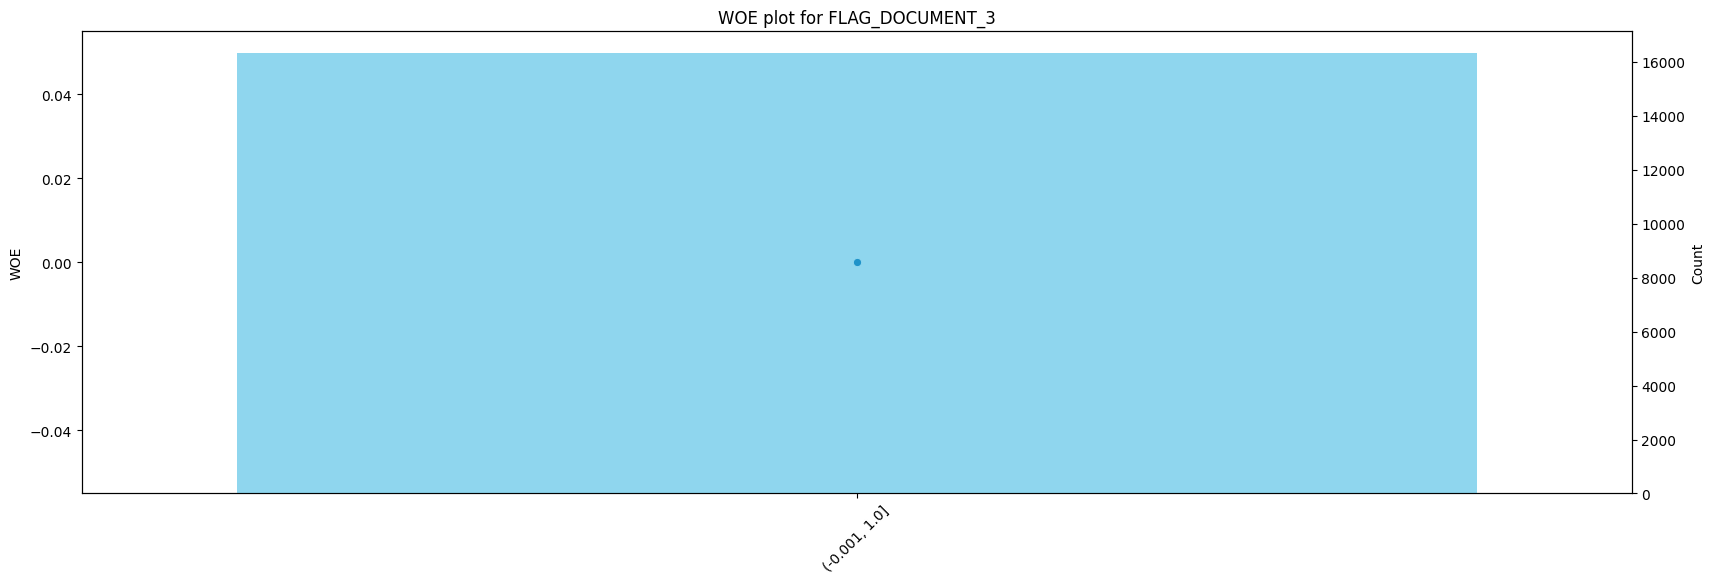

FLAG_DOCUMENT_3 successfully loaded
IV for FLAG_EMP_PHONE with 1 bins: 0.0


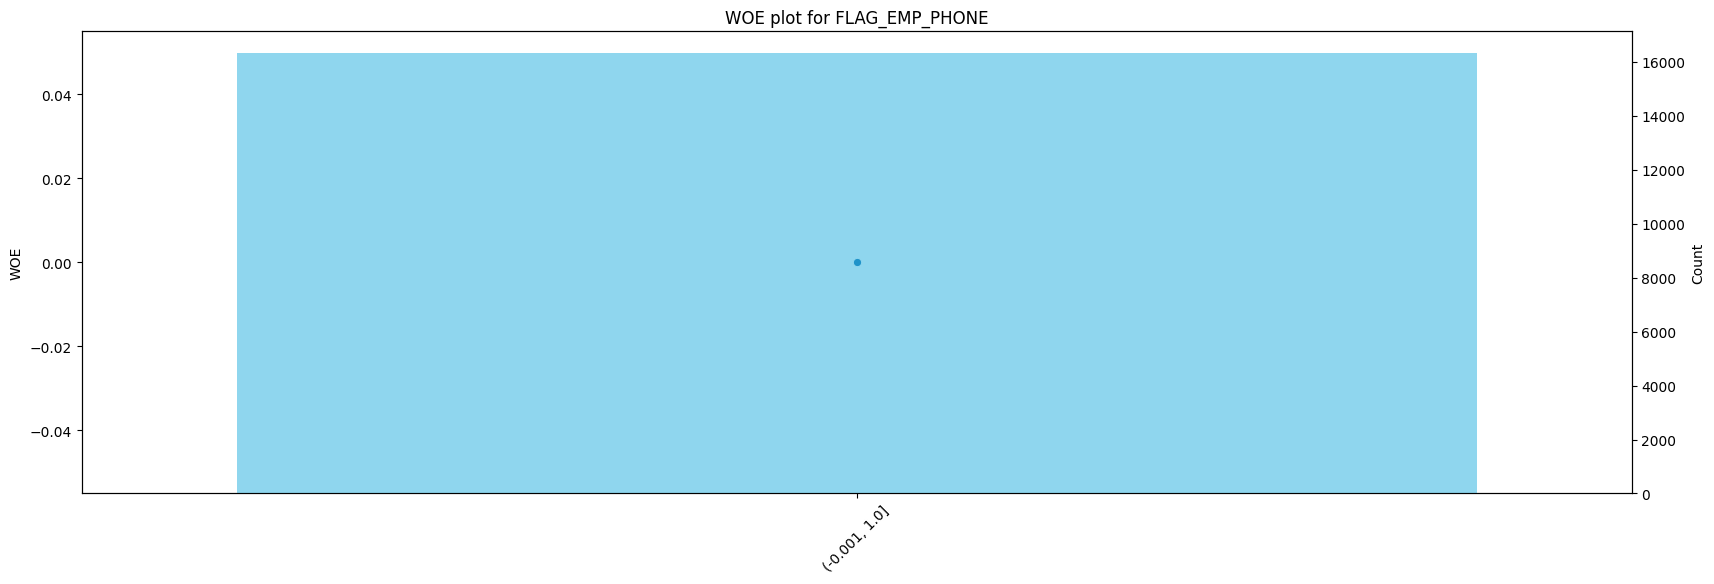

FLAG_EMP_PHONE successfully loaded
IV for DAYS_EMPLOYED with 20 bins: 0.0125


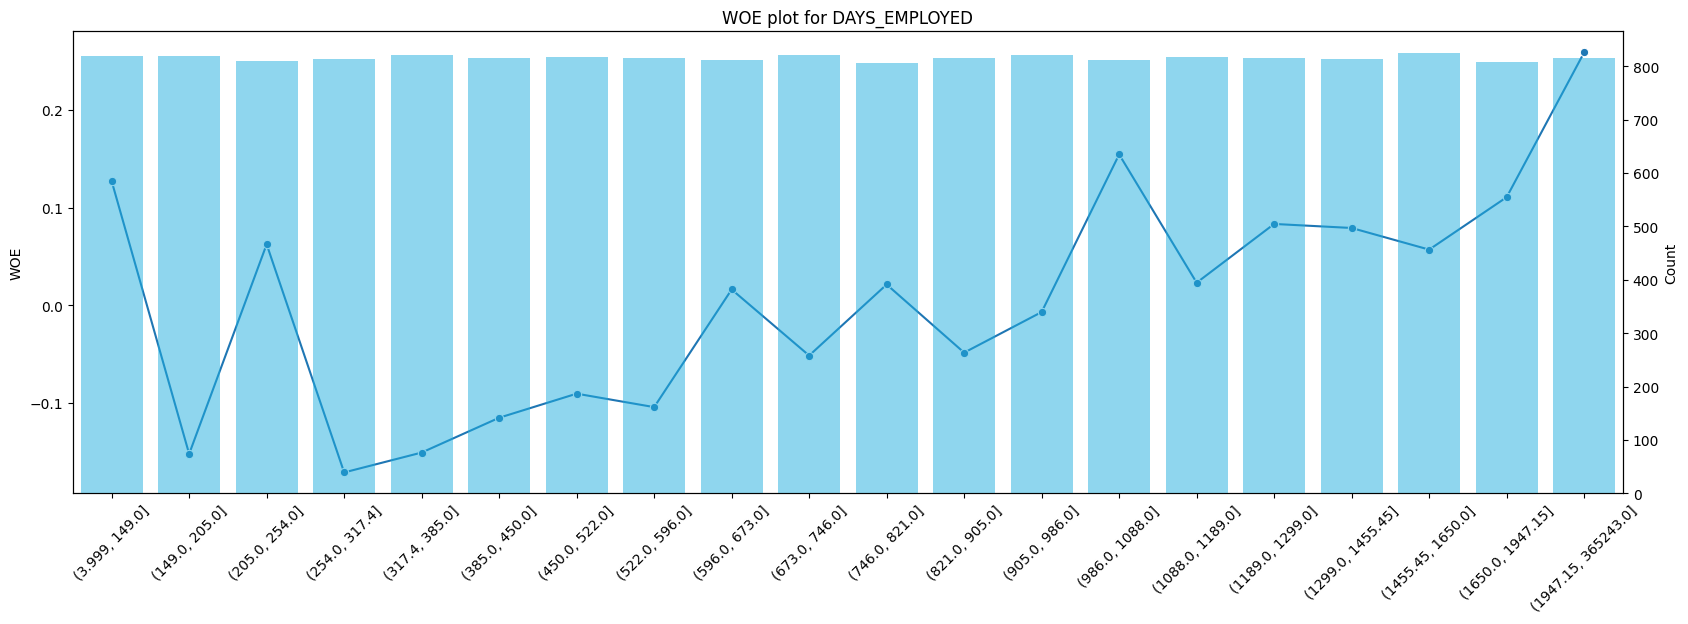

DAYS_EMPLOYED successfully loaded
IV for AMT_CREDIT_MAX_OVERDUE with 5 bins: 0.0233


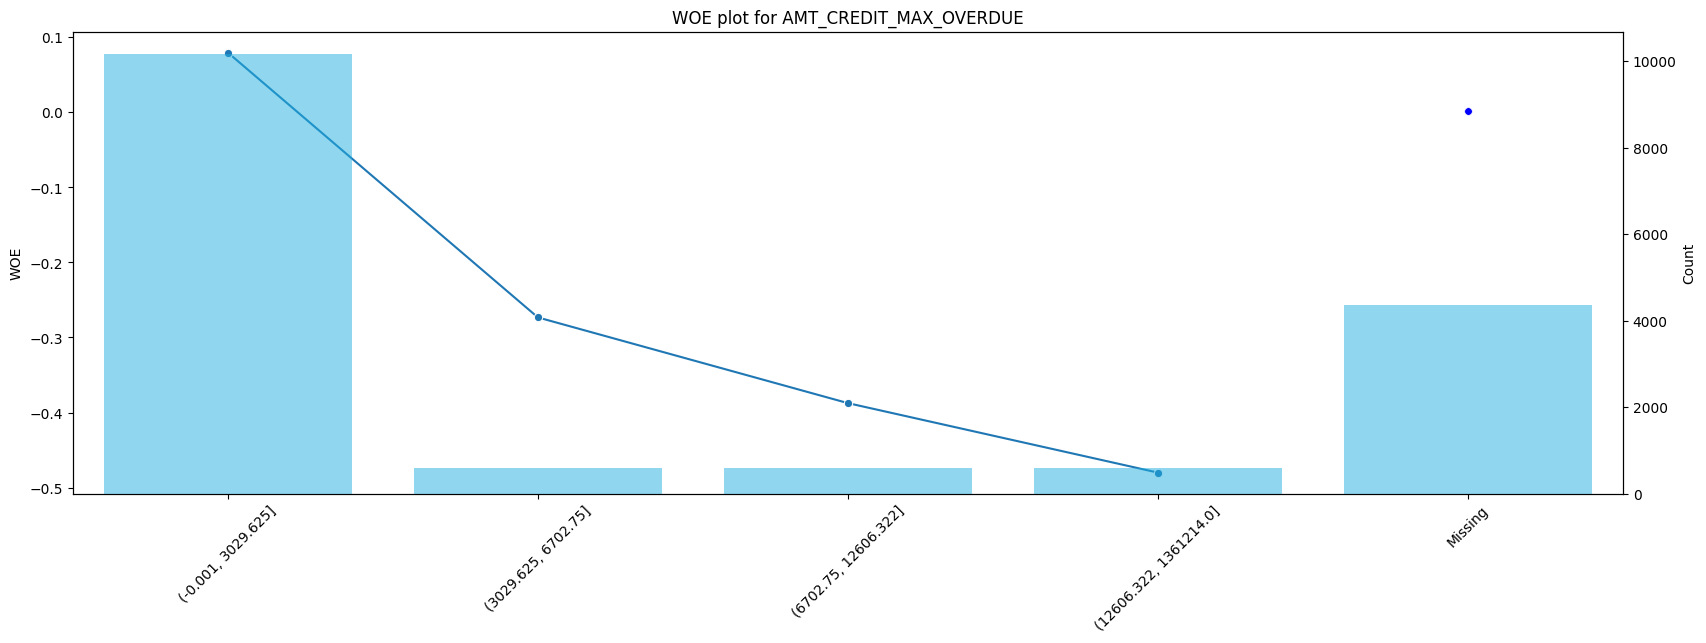

AMT_CREDIT_MAX_OVERDUE successfully loaded
IV for AMT_REQ_CREDIT_BUREAU_MON with 3 bins: 0.0005


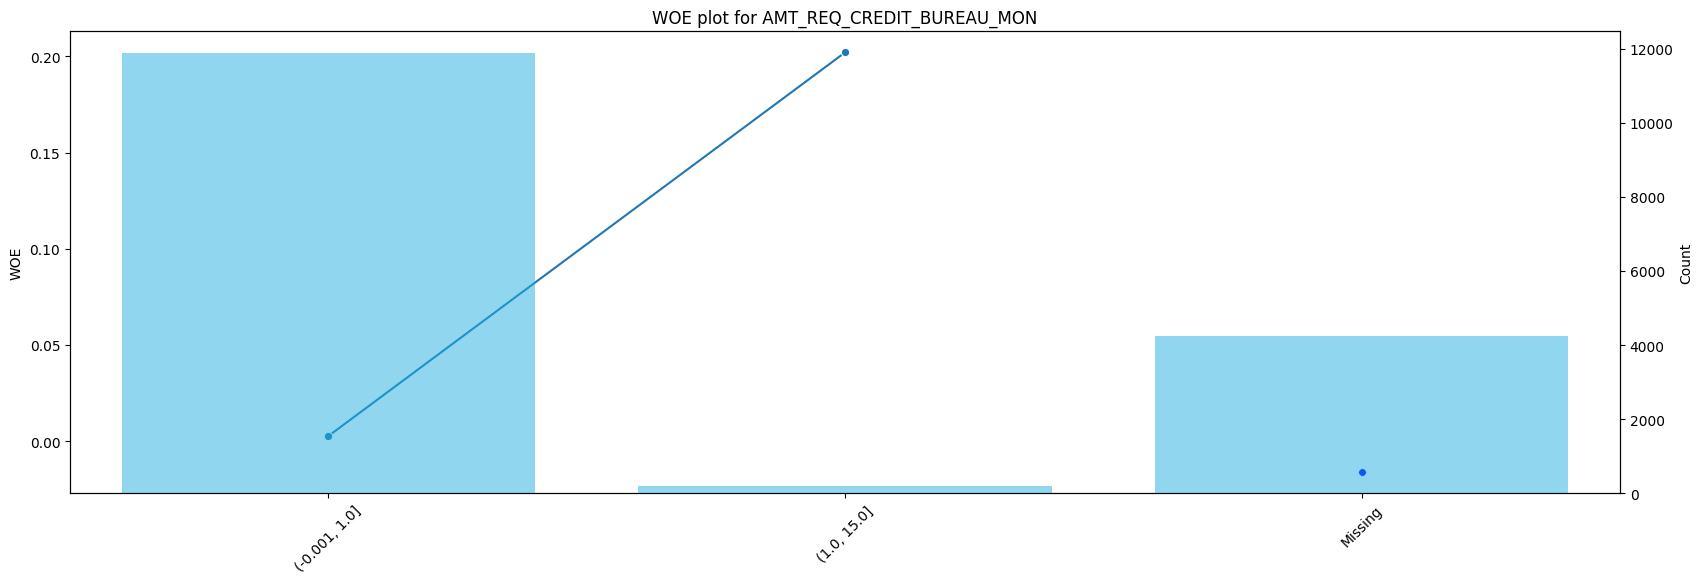

AMT_REQ_CREDIT_BUREAU_MON successfully loaded
IV for FLAG_DOCUMENT_18 with 1 bins: 0.0


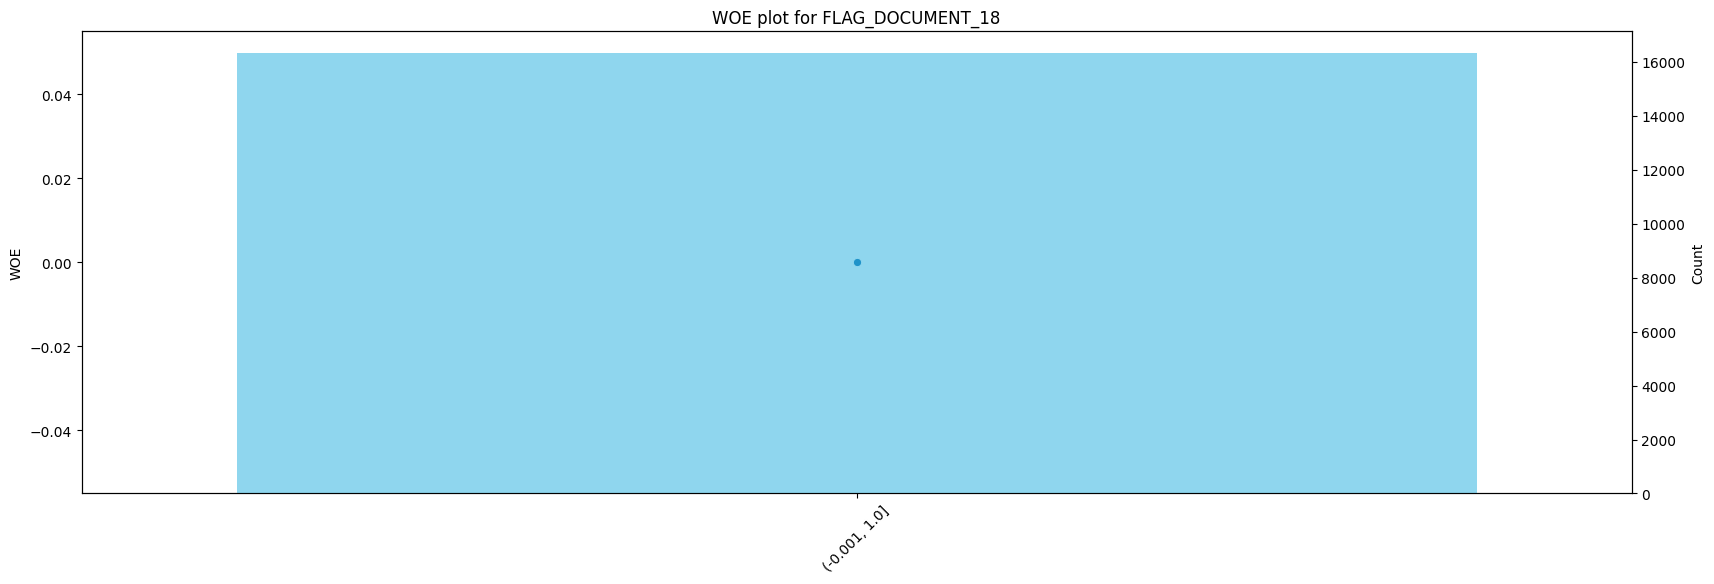

FLAG_DOCUMENT_18 successfully loaded
IV for CNT_FAM_MEMBERS with 3 bins: 0.0066


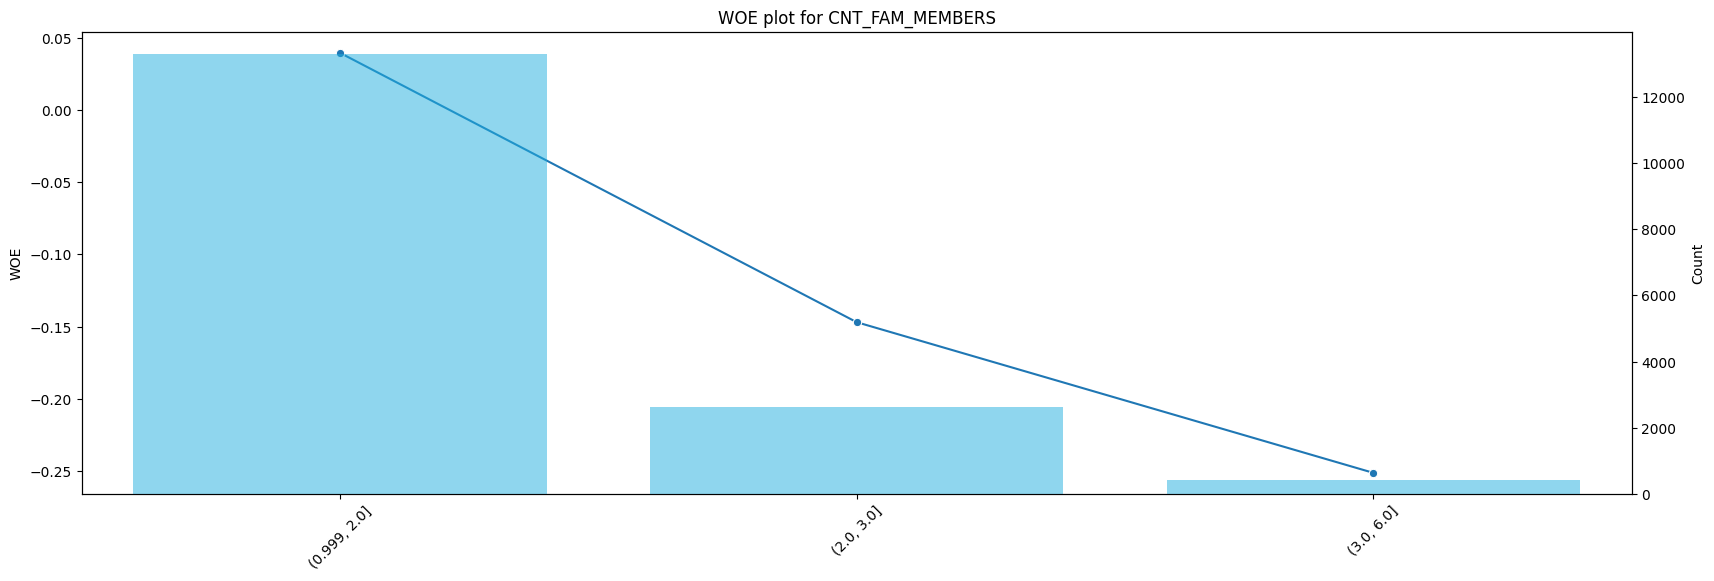

CNT_FAM_MEMBERS successfully loaded
IV for NUM_MICROLOAN with 2 bins: 0.0


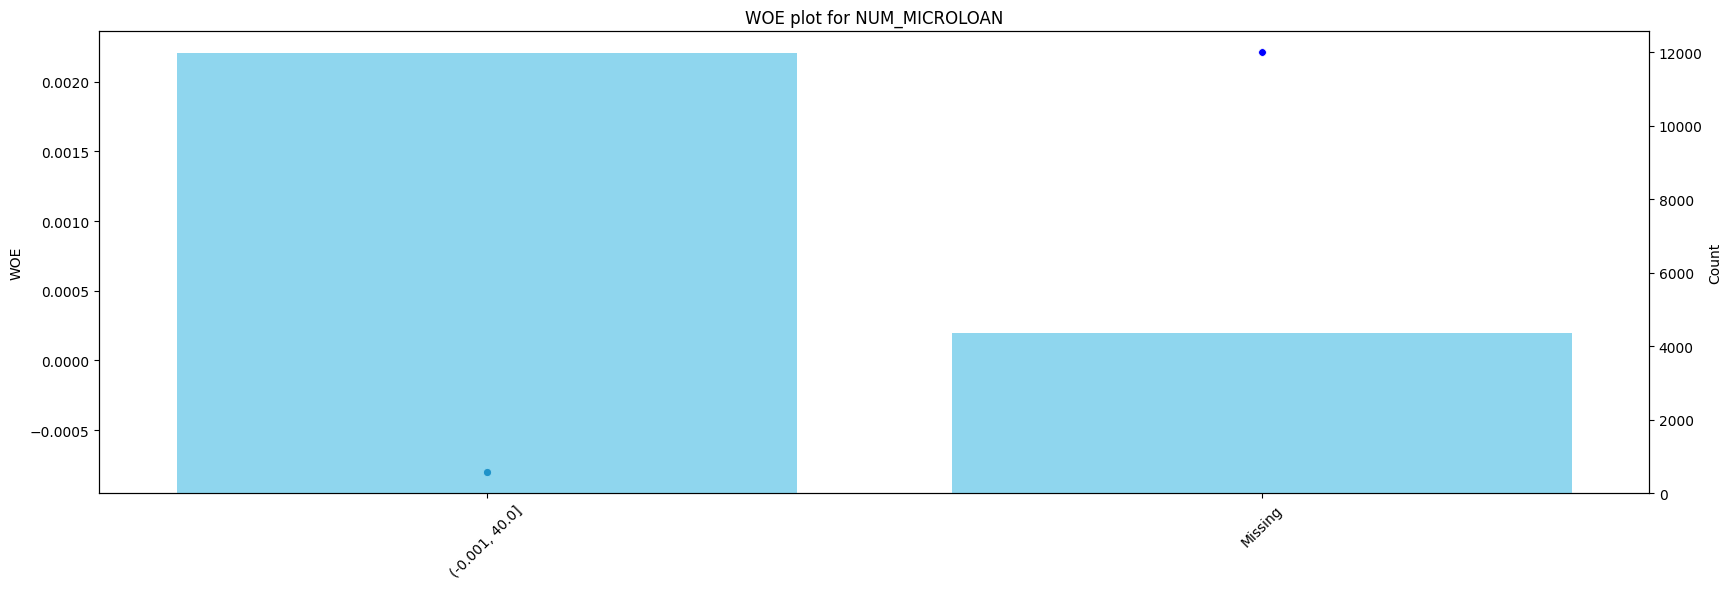

NUM_MICROLOAN successfully loaded
IV for AMT_INCOME_TOTAL with 16 bins: 0.0323


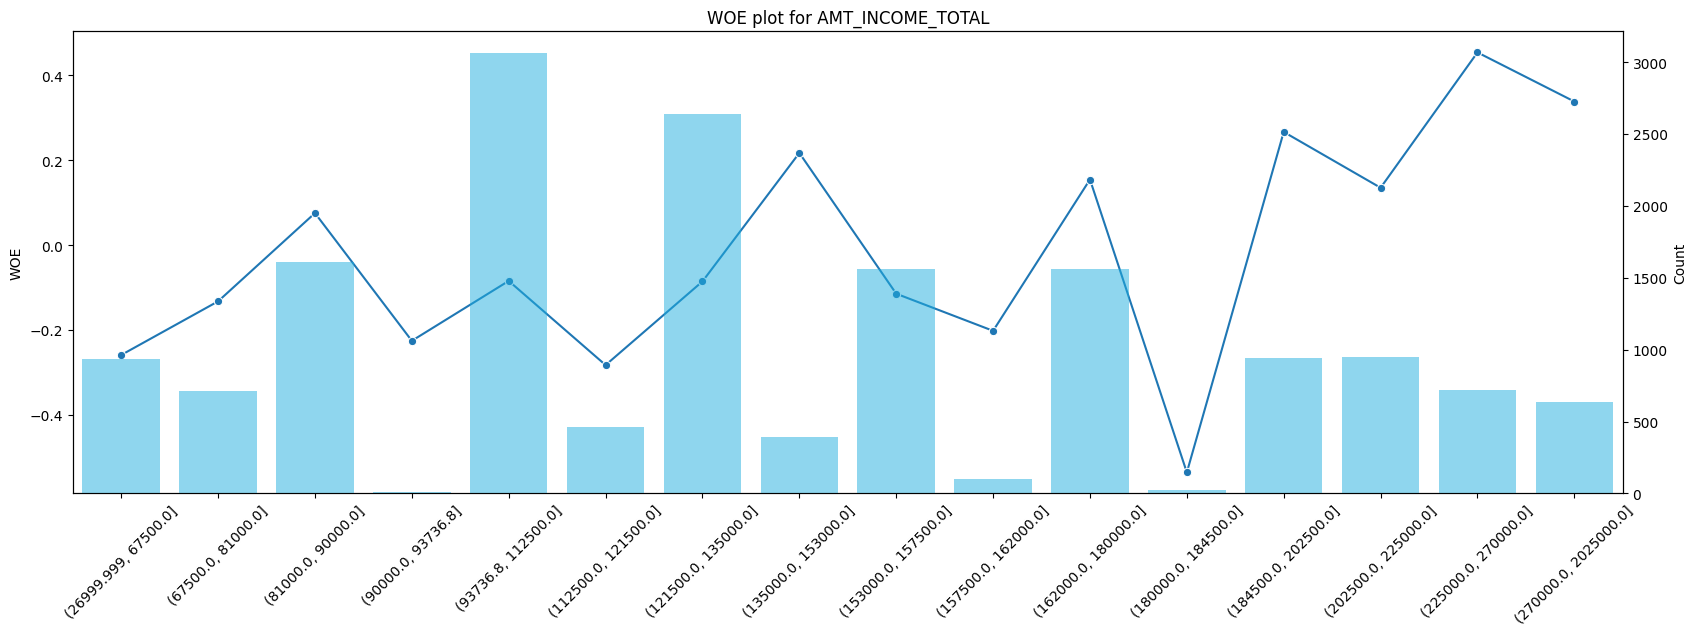

AMT_INCOME_TOTAL successfully loaded
IV for FLAG_DOCUMENT_13 with 1 bins: 0.0


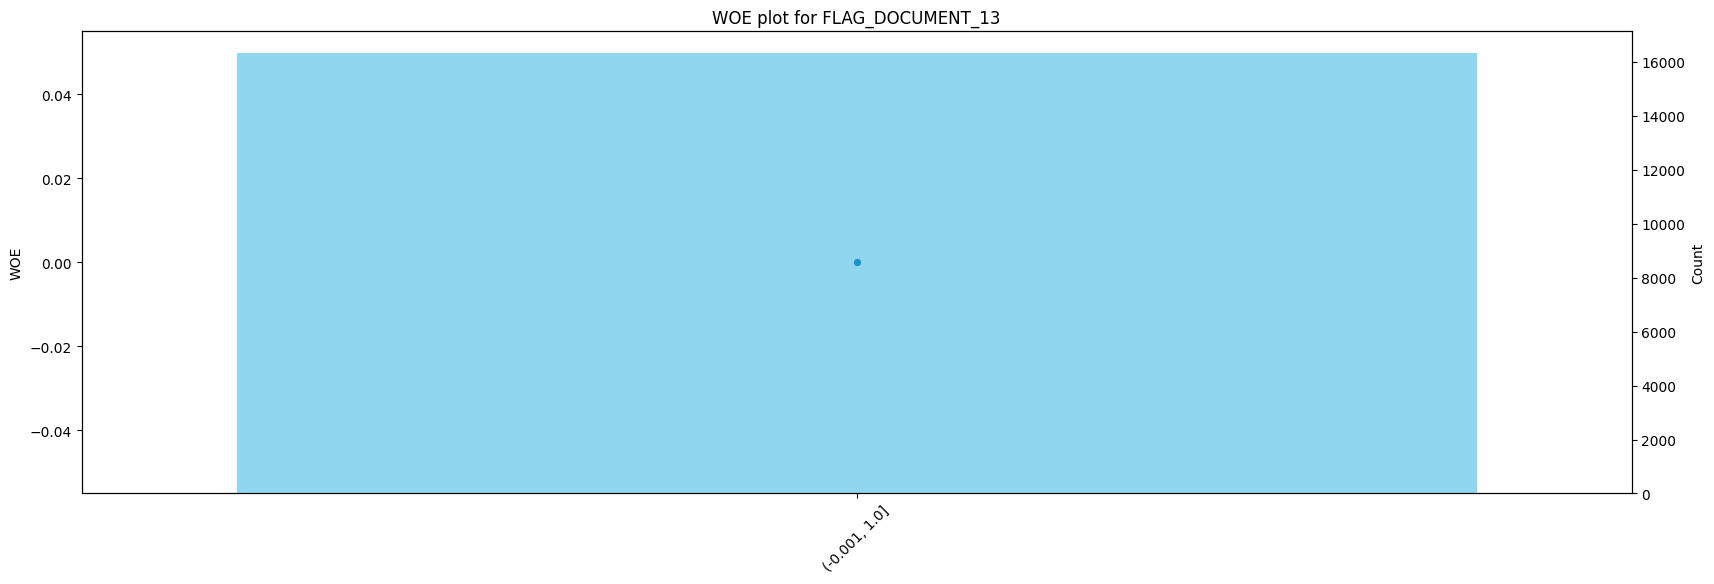

FLAG_DOCUMENT_13 successfully loaded
IV for REGION_POPULATION_RELATIVE with 20 bins: 0.0639


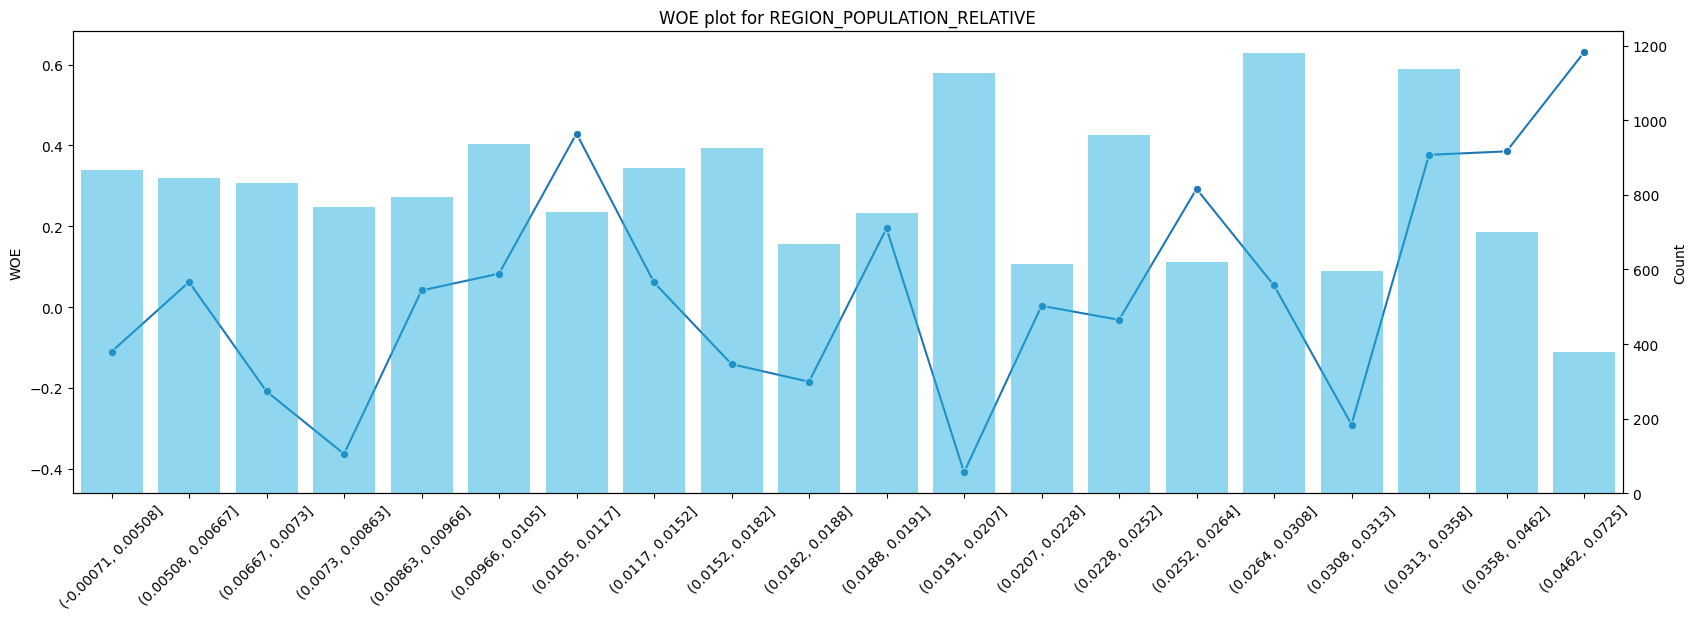

REGION_POPULATION_RELATIVE successfully loaded
IV for AMT_REQ_CREDIT_BUREAU_YEAR with 7 bins: 0.0053


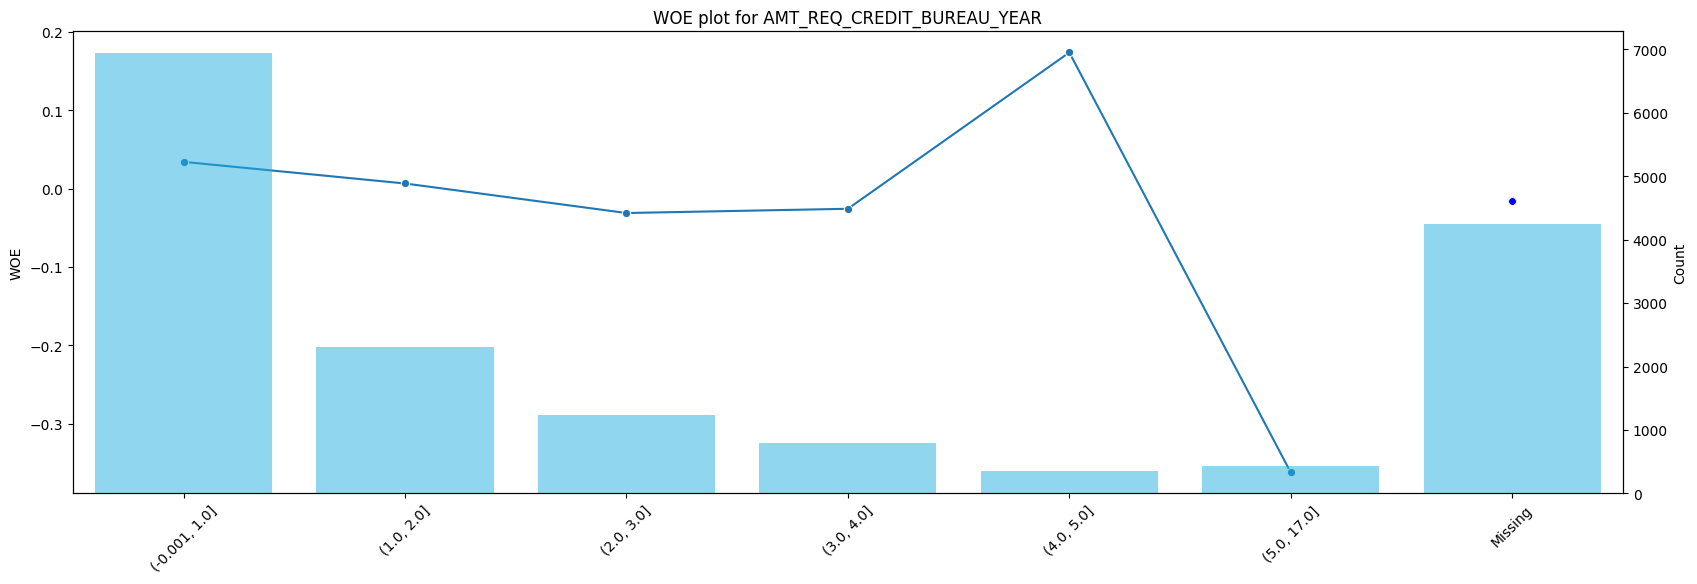

AMT_REQ_CREDIT_BUREAU_YEAR successfully loaded
IV for FLAG_OWN_REALTY with 1 bins: 0.0


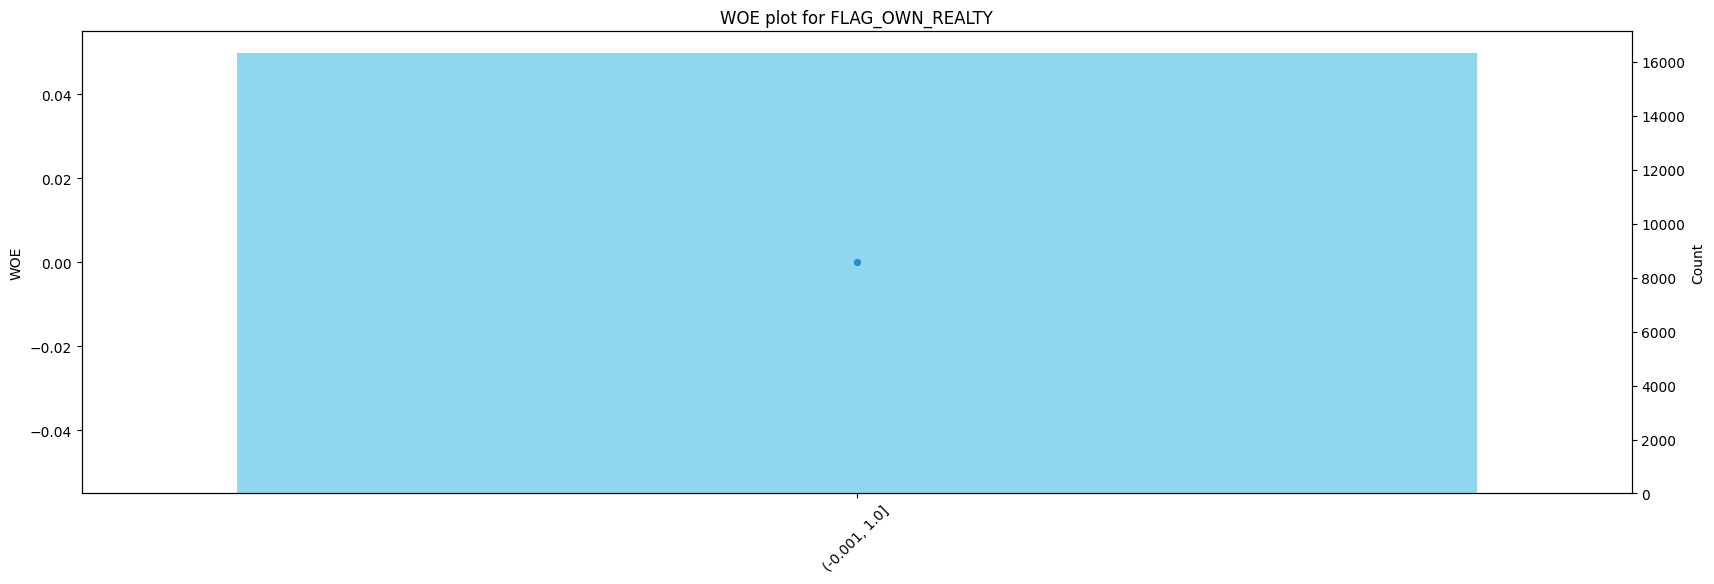

FLAG_OWN_REALTY successfully loaded
IV for FLAG_DOCUMENT_11 with 1 bins: 0.0


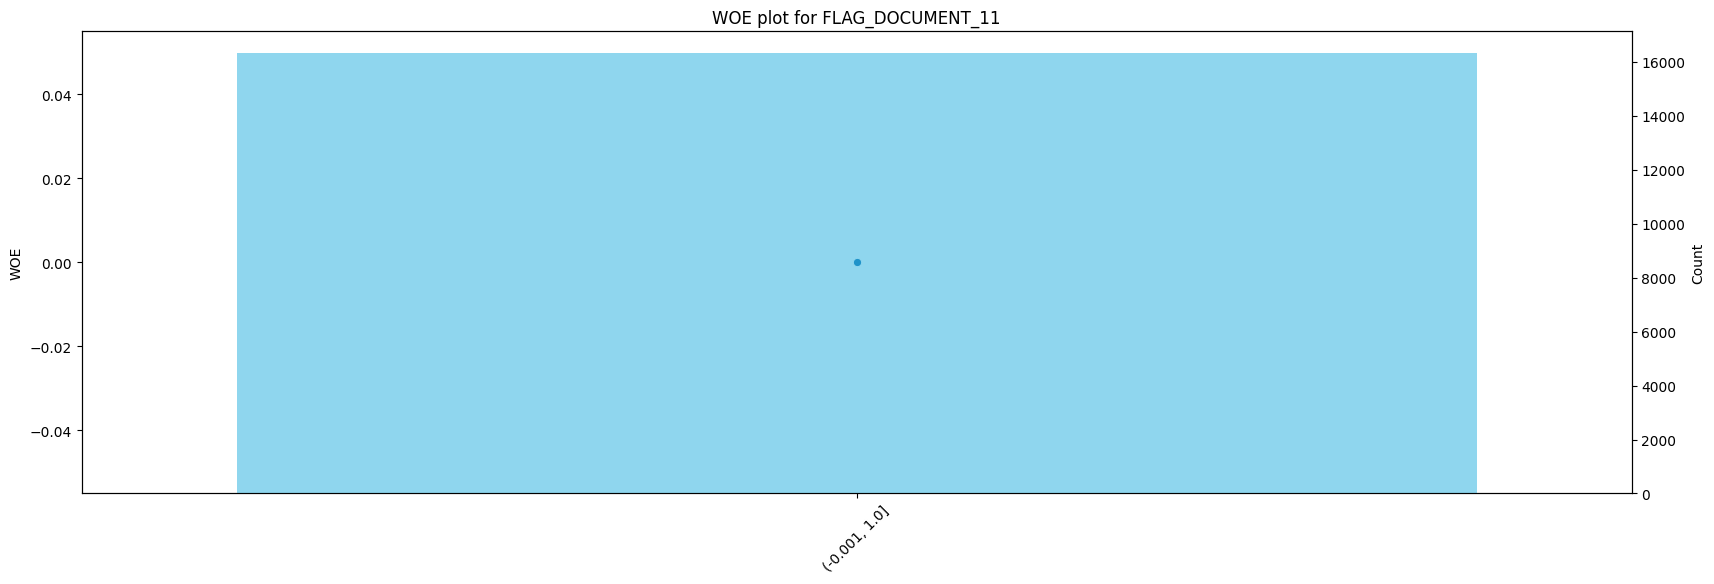

FLAG_DOCUMENT_11 successfully loaded
IV for FLAG_DOCUMENT_14 with 1 bins: 0.0


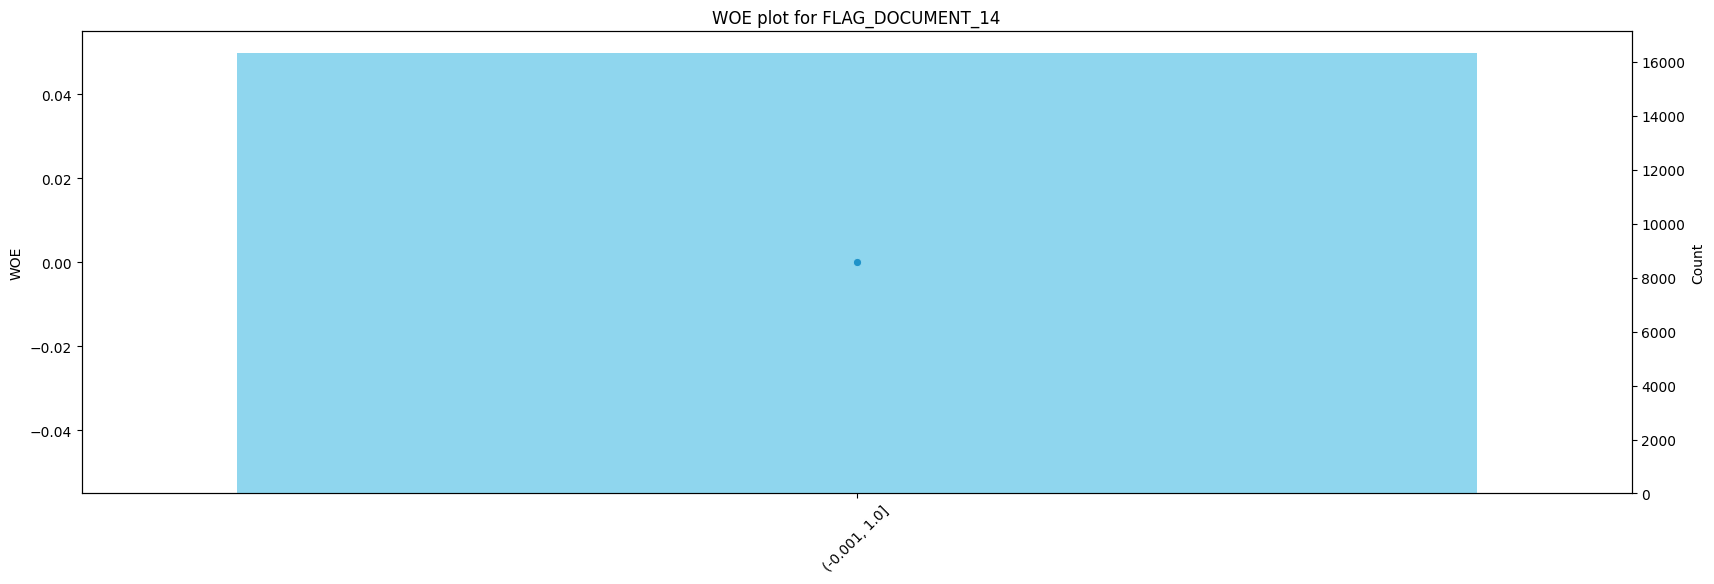

FLAG_DOCUMENT_14 successfully loaded
IV for AMT_GOODS_PRICE with 16 bins: 0.0557


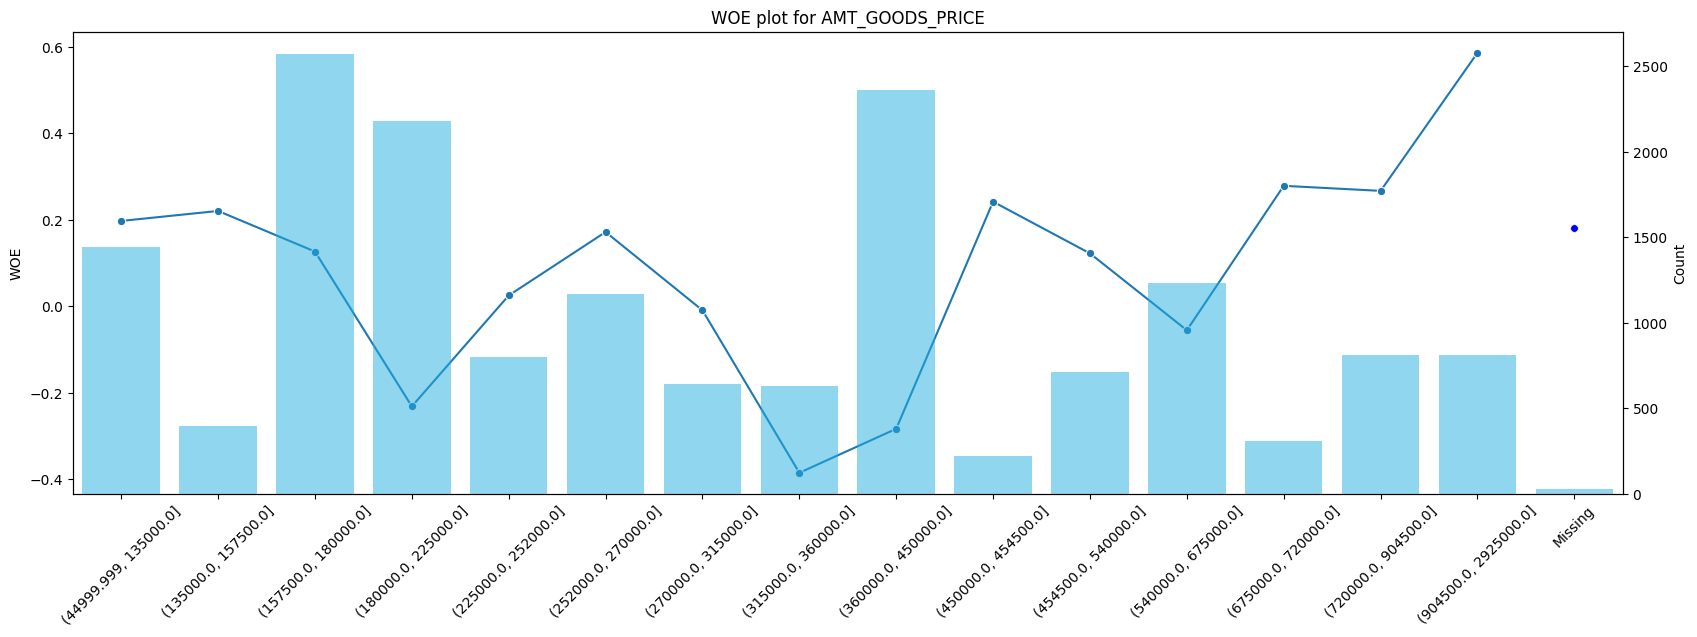

AMT_GOODS_PRICE successfully loaded
IV for FLAG_DOCUMENT_16 with 1 bins: 0.0


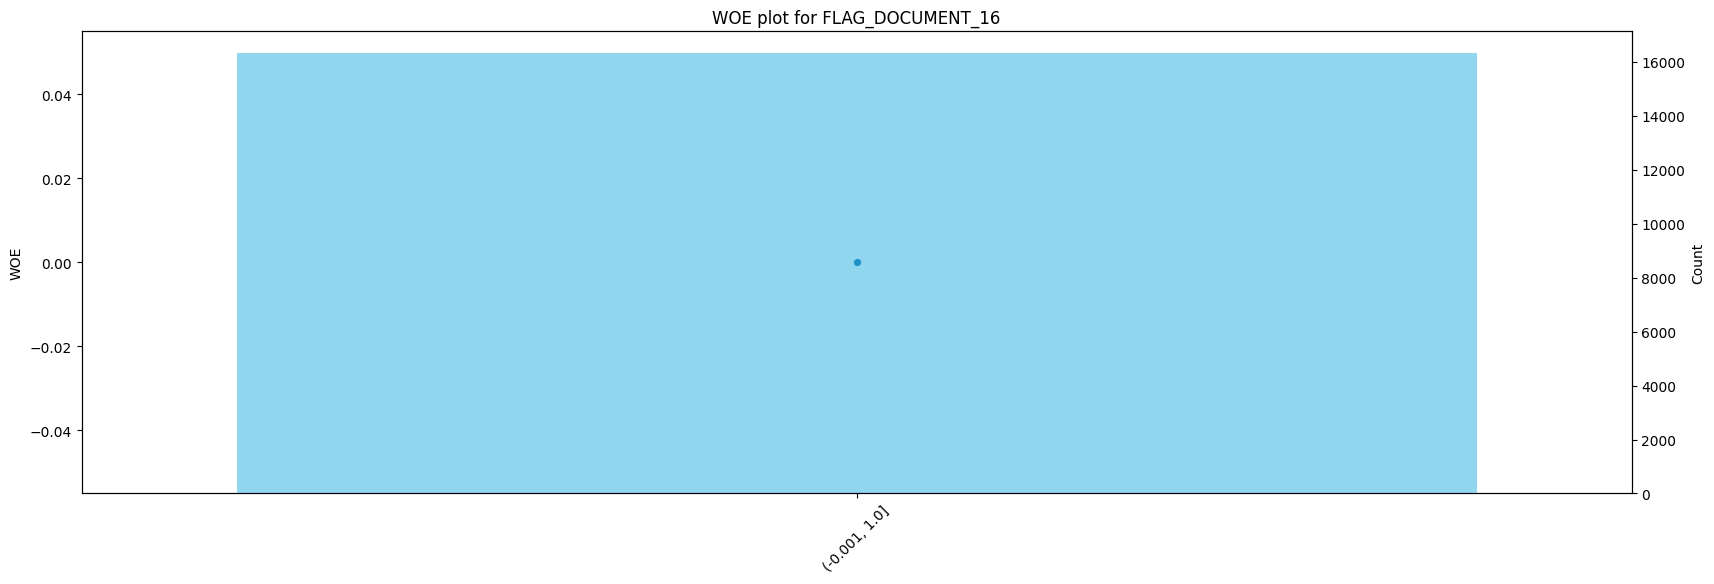

FLAG_DOCUMENT_16 successfully loaded
IV for NUMCLOSED with 7 bins: 0.009


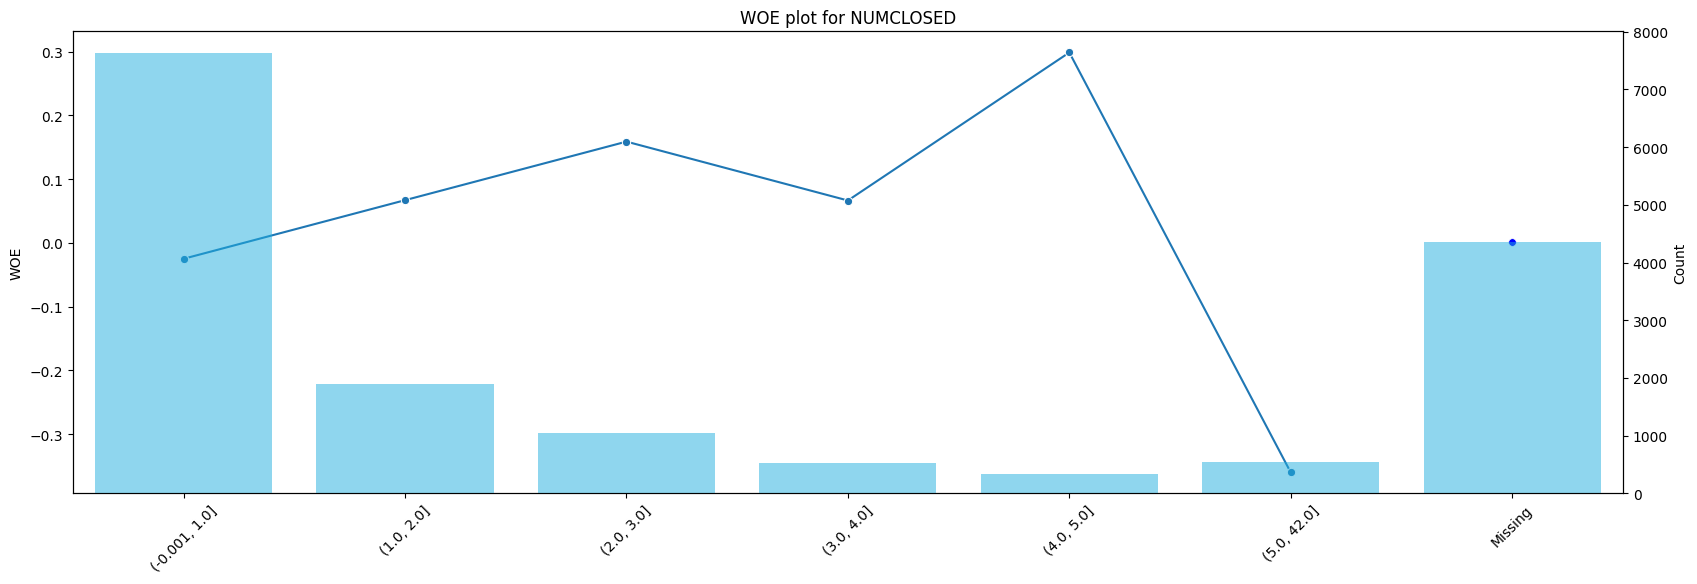

NUMCLOSED successfully loaded
IV for AVG_OVERDUE_DAYS with 2 bins: 0.0


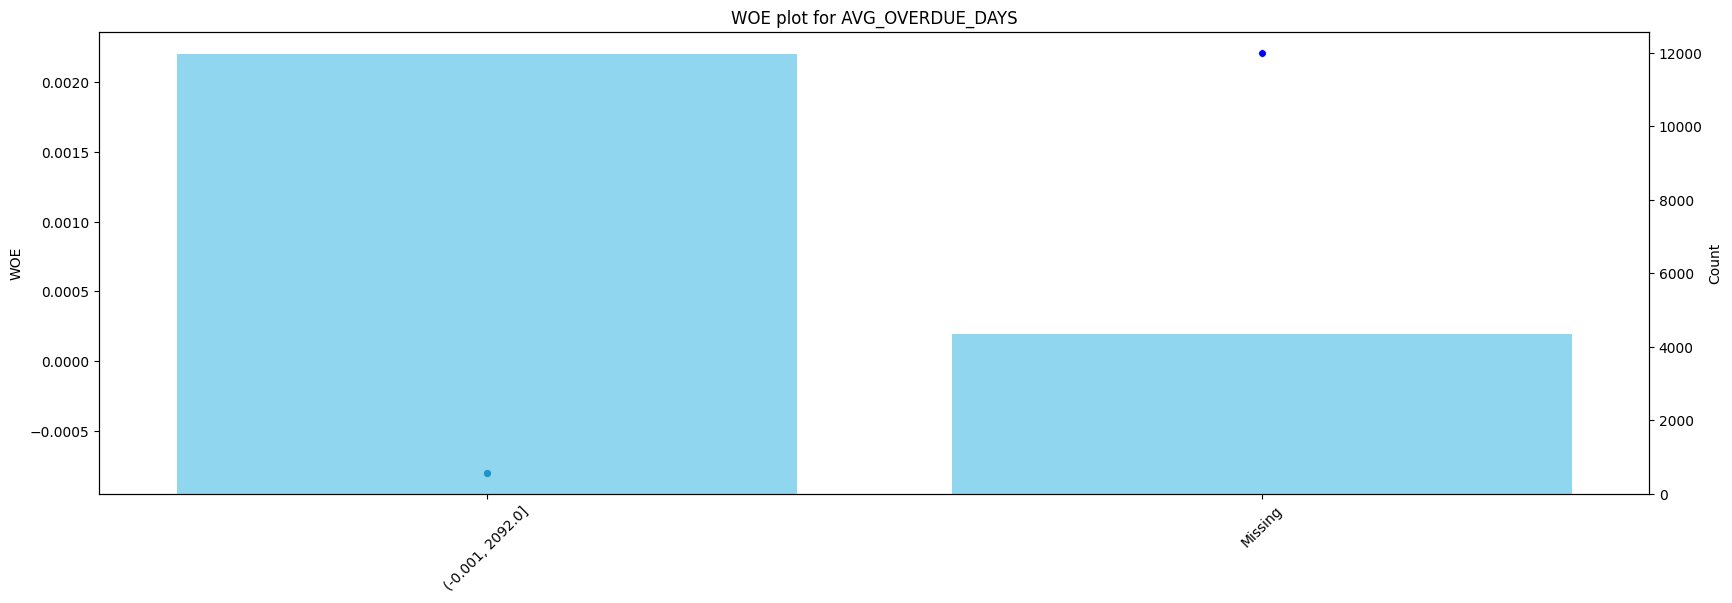

AVG_OVERDUE_DAYS successfully loaded


In [20]:
#Calculate WOE and IV for 30 columns
encoded_data = pd.read_csv("merged_encoded_data.csv")

def woe_iv(data, variable_name):

    working_data = data.copy()

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace = True)

    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']

    variable_data['Events'] =working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events']/sum(variable_data['Events'])

    variable_data['%_of_Non_Events'] = variable_data['Non_Events']/sum(variable_data['Non_Events'])
    variable_data

    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

    variable_data['IV'] = (variable_data['%_of_Non_Events']-variable_data['%_of_Events']) * variable_data['WOE']

    IV = sum(variable_data['IV'])
    return(IV, variable_data)

# test the function

def woe_iv_plot(data, variable_name):
    IV, variable_data = woe_iv(data, variable_name)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(IV,4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot

    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)

    ax2 = ax1.twinx()

    # plot the bin counts
    sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    plt.title("WOE plot for " + variable_name)
    plt.show()

variables = [
    "EXT_SOURCE_1",
    "AVG_FREQ_CRED_APP",
    "REGION_RATING_CLIENT_W_CITY",
    "OVERDUE_RATIO",
    "NUMACTIVE",
    "DAYS_ID_PUBLISH",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "AMT_CREDIT_SUM_OVERDUE",
    "FLAG_DOCUMENT_6",
    "DAYS_BIRTH",
    "FLAG_DOCUMENT_3",
    "FLAG_EMP_PHONE",
    "DAYS_EMPLOYED",
    "AMT_CREDIT_MAX_OVERDUE",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "FLAG_DOCUMENT_18",
    "CNT_FAM_MEMBERS",
    "NUM_MICROLOAN",
    "AMT_INCOME_TOTAL",
    "FLAG_DOCUMENT_13",
    "REGION_POPULATION_RELATIVE",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "FLAG_OWN_REALTY",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_14",
    "AMT_GOODS_PRICE",
    "FLAG_DOCUMENT_16",
    "NUMCLOSED",
    "AVG_OVERDUE_DAYS"
]


#Do fine classing
for variable in variables:
    woe_bin_data = encoded_data.loc[:,(variable, 'TARGET')]
    q = 20  # Start with 20 bins
    while q > 1:
        try:
            woe_bin_data['Bin_Range'] = pd.qcut(encoded_data[variable], q=q, duplicates='drop')
            break  # Exit loop if successful
        except ValueError:
            q -= 1  # Reduce q if there's an error
    woe_iv(woe_bin_data,variable)
    woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
    woe_bin_data['Bin_Range'].fillna('Missing', inplace = True)
    woe_iv_plot(woe_bin_data, variable) #comment out because if print out all 30 have to keep scrolling
    print(variable + " successfully loaded")


##Step 8: Coarse Classing for variables with IV > 0.02

EXT_SOURCE_1, AVG_FREQ_CRED_APP, REGION_RATING_CLIENT_W_CITY, NUMACTIVE, DAYS_ID_PUBLISH, AMT_INCOME_TOTAL, REGION_POPULATION_RELATIVE, AMT_GOODS_PRICE

IV for EXT_SOURCE_1 with 5 bins: 0.1392


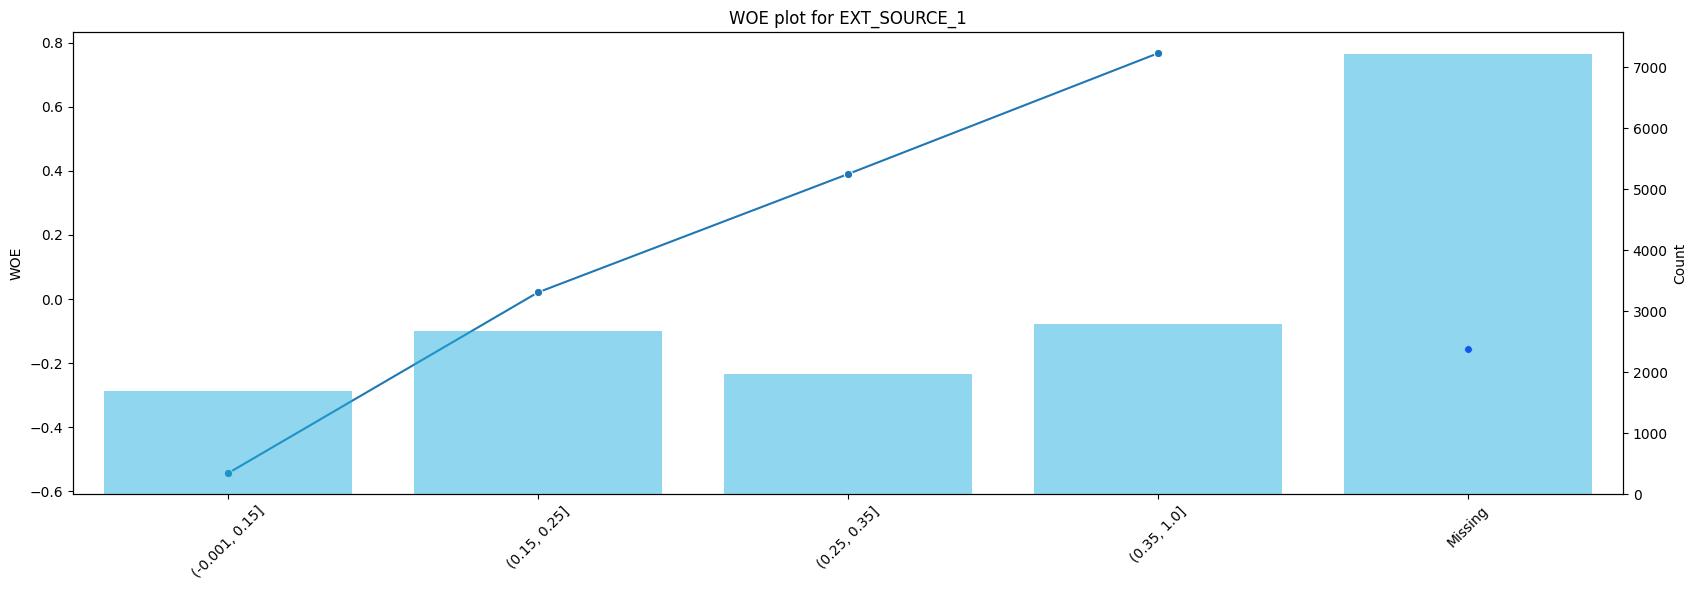

In [21]:
# Following few code blocks would be for the 9 chosen variables for coarse classing to do credit scorecard
# Coarse classing for EXT_SOURCE_1
bin_edges = [0, 0.150, 0.250, 0.350, 1]
variable = 'EXT_SOURCE_1'
encoded_data_working = encoded_data.copy()
# create groupings based on specified bin edges
encoded_data_working['Bin_Range'] = pd.cut(encoded_data[variable], bins = bin_edges, include_lowest= True)
encoded_data_working['Bin_Range'].value_counts().sort_index()

woe_iv(encoded_data_working, variable)
woe_iv_plot(encoded_data_working,variable)

IV for AVG_FREQ_CRED_APP with 5 bins: 0.0547


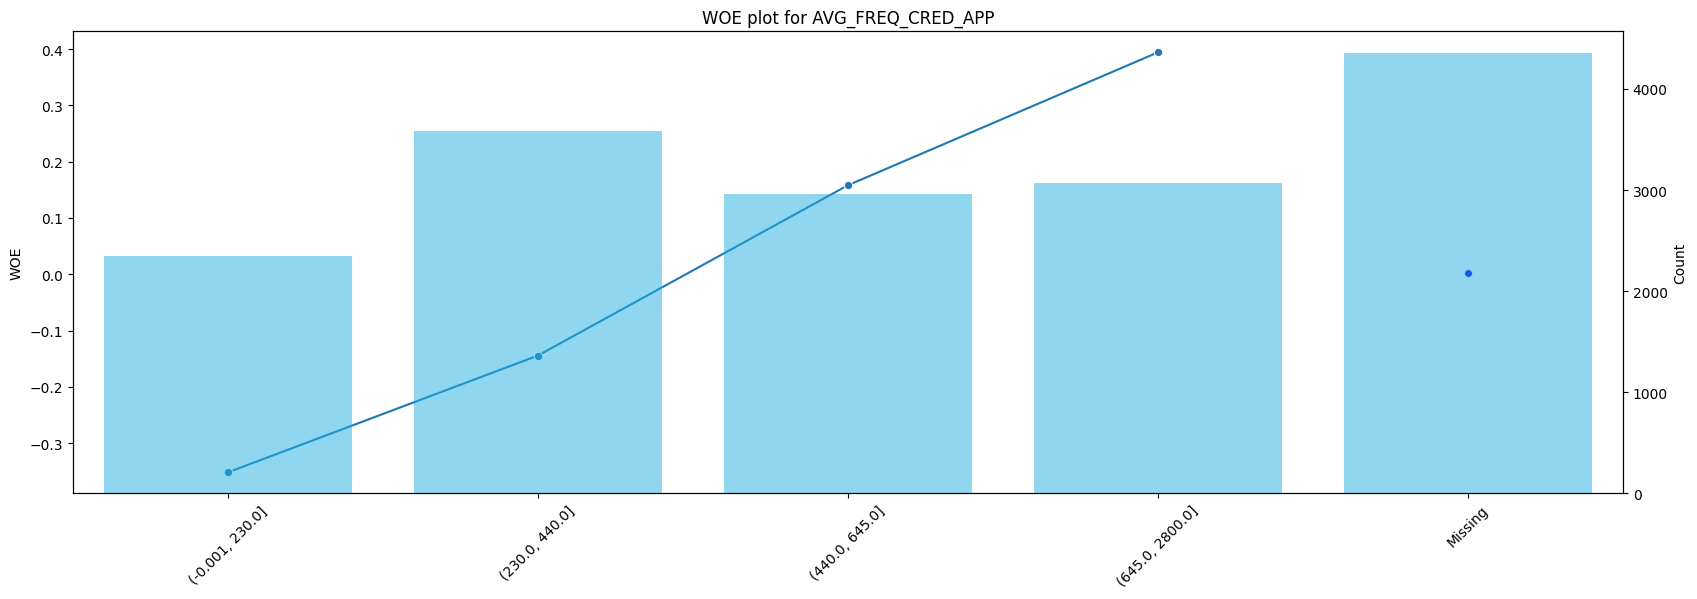

In [22]:
#Coarse classing for AVG_FREQ_CRED_APP
bin_edges = [0, 230, 440, 645, 2800]
variable = 'AVG_FREQ_CRED_APP'

# create groupings based on specified bin edges
encoded_data_working['Bin_Range'] = pd.cut(encoded_data[variable], bins = bin_edges, include_lowest= True)
encoded_data_working['Bin_Range'].value_counts().sort_index()

woe_iv(encoded_data_working, variable)
woe_iv_plot(encoded_data_working,variable)

IV for REGION_RATING_CLIENT_W_CITY with 3 bins: 0.0494


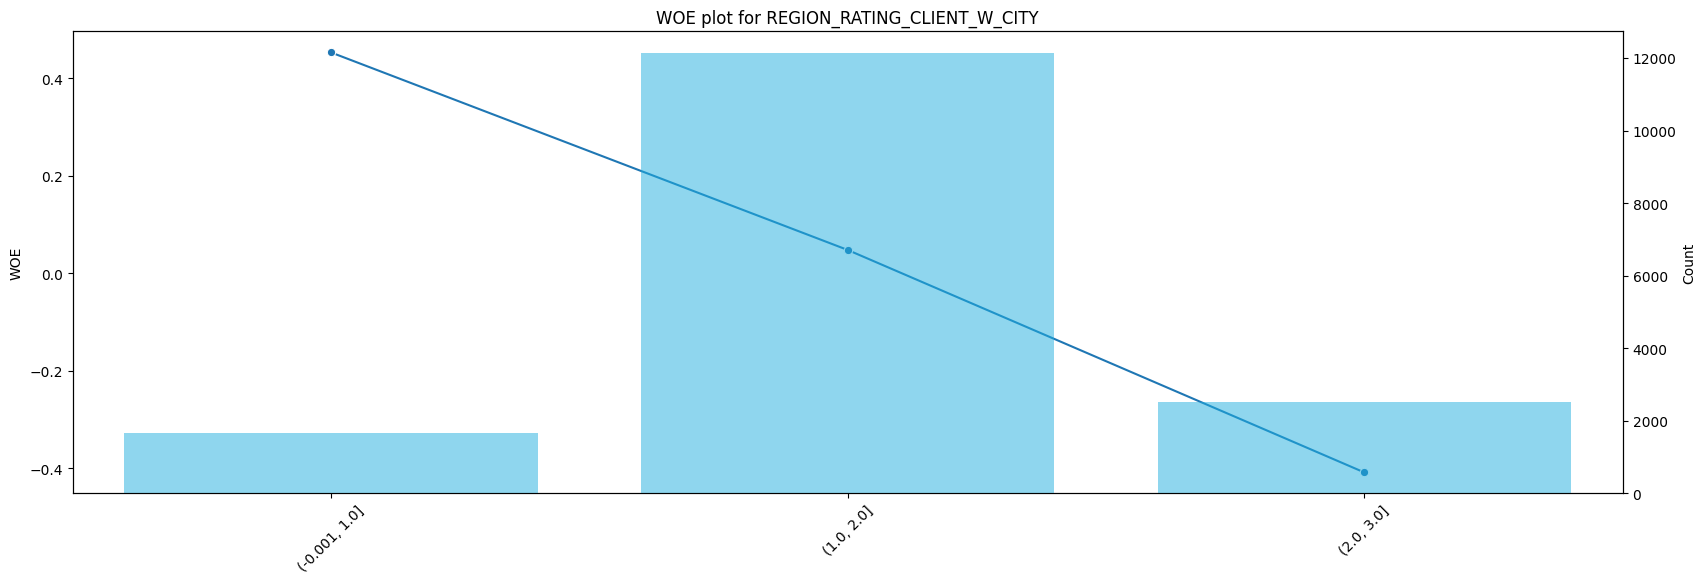

In [23]:
#Coarse classimg for REGION_RATING_CLIENT_W_CITY
bin_edges = [0, 1, 2, 3]
variable = 'REGION_RATING_CLIENT_W_CITY'

# create groupings based on specified bin edges
encoded_data_working['Bin_Range'] = pd.cut(encoded_data[variable], bins = bin_edges, include_lowest= True)
encoded_data_working['Bin_Range'].value_counts().sort_index()

woe_iv(encoded_data_working, variable)
woe_iv_plot(encoded_data_working,variable)

IV for NUMACTIVE with 4 bins: 0.026


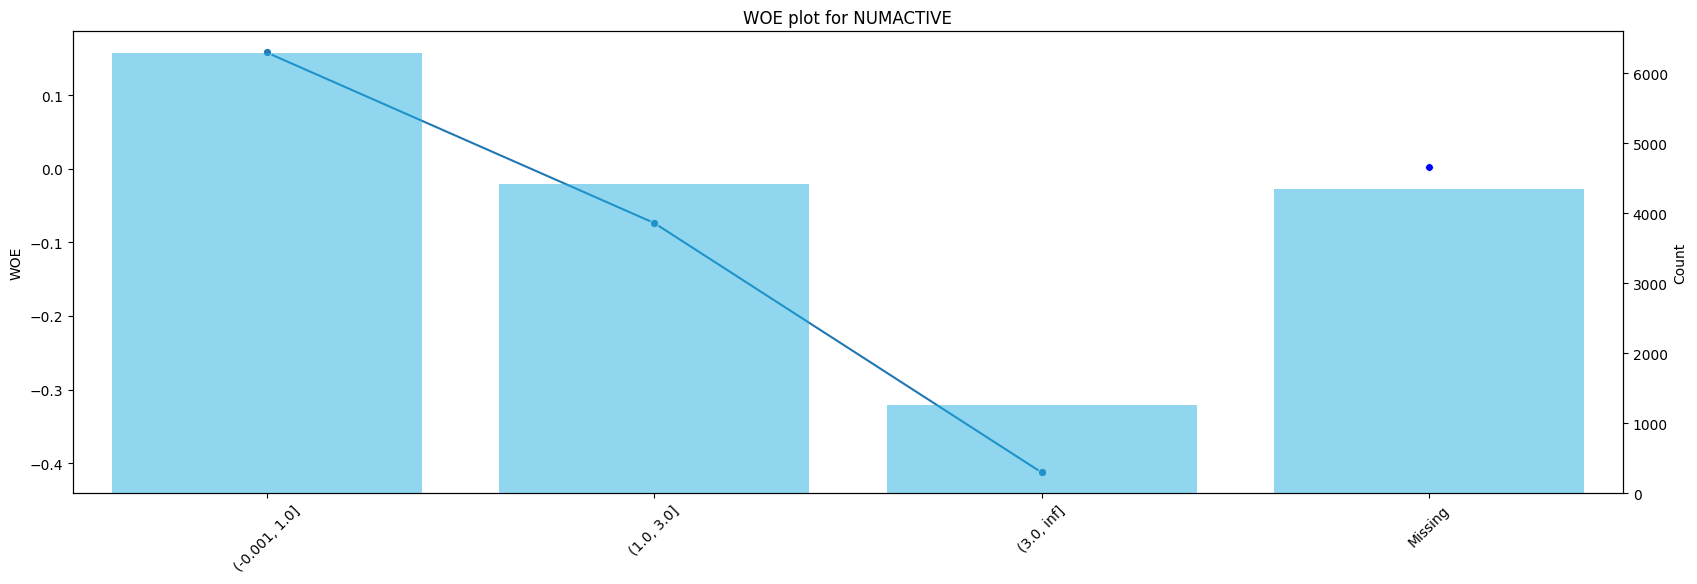

In [24]:
#Coarse Classing for NUMACTIVE
bin_edges = [0, 1, 3, np.inf]
variable = 'NUMACTIVE'

# create groupings based on specified bin edges
encoded_data_working['Bin_Range'] = pd.cut(encoded_data[variable], bins = bin_edges, include_lowest= True)
encoded_data_working['Bin_Range'].value_counts().sort_index()

woe_iv(encoded_data_working, variable)
woe_iv_plot(encoded_data_working,variable)

IV for DAYS_ID_PUBLISH with 4 bins: 0.0245


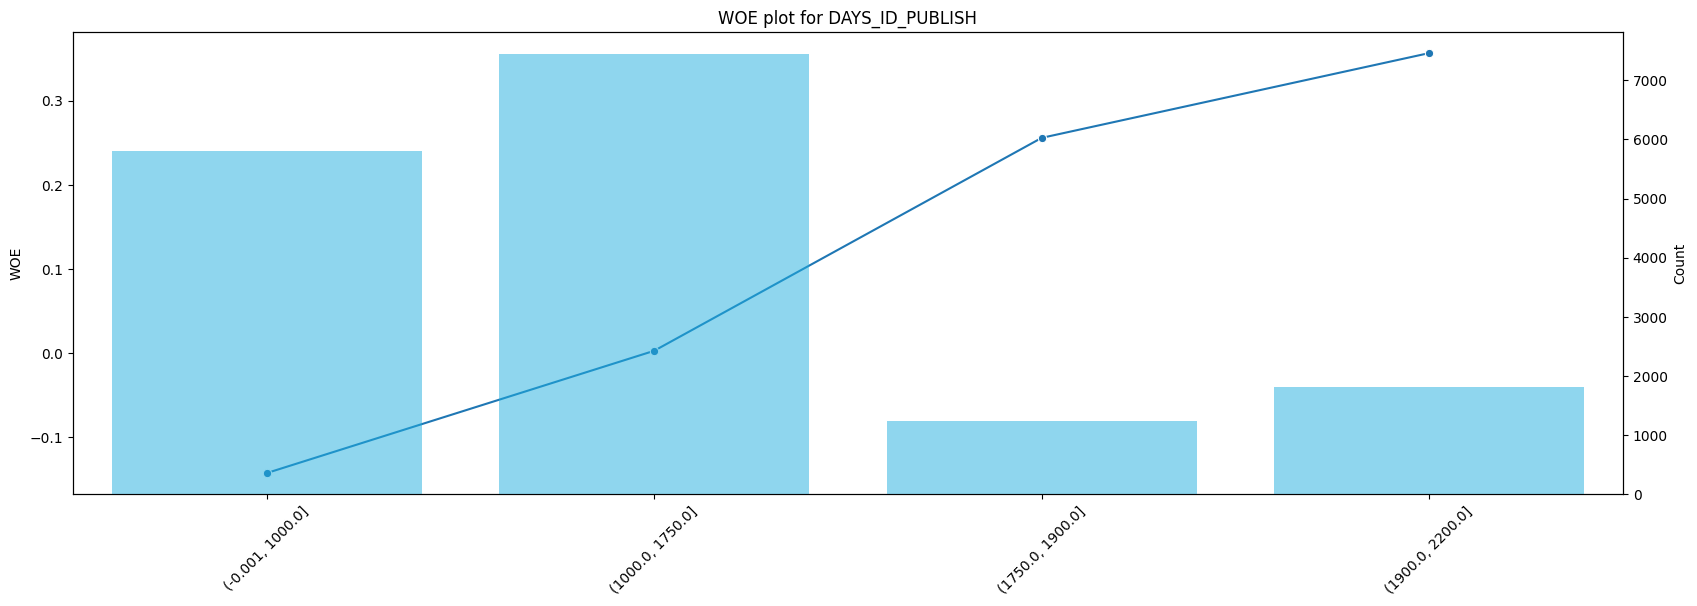

In [25]:
#Coarse Classing for DAYS_ID_PUBLISH
bin_edges = [0, 1000, 1750, 1900, 2200]
variable = 'DAYS_ID_PUBLISH'

# create groupings based on specified bin edges
encoded_data_working['Bin_Range'] = pd.cut(encoded_data[variable], bins = bin_edges, include_lowest= True)
encoded_data_working['Bin_Range'].value_counts().sort_index()

woe_iv(encoded_data_working, variable)
woe_iv_plot(encoded_data_working,variable)

IV for AMT_INCOME_TOTAL with 4 bins: 0.0183


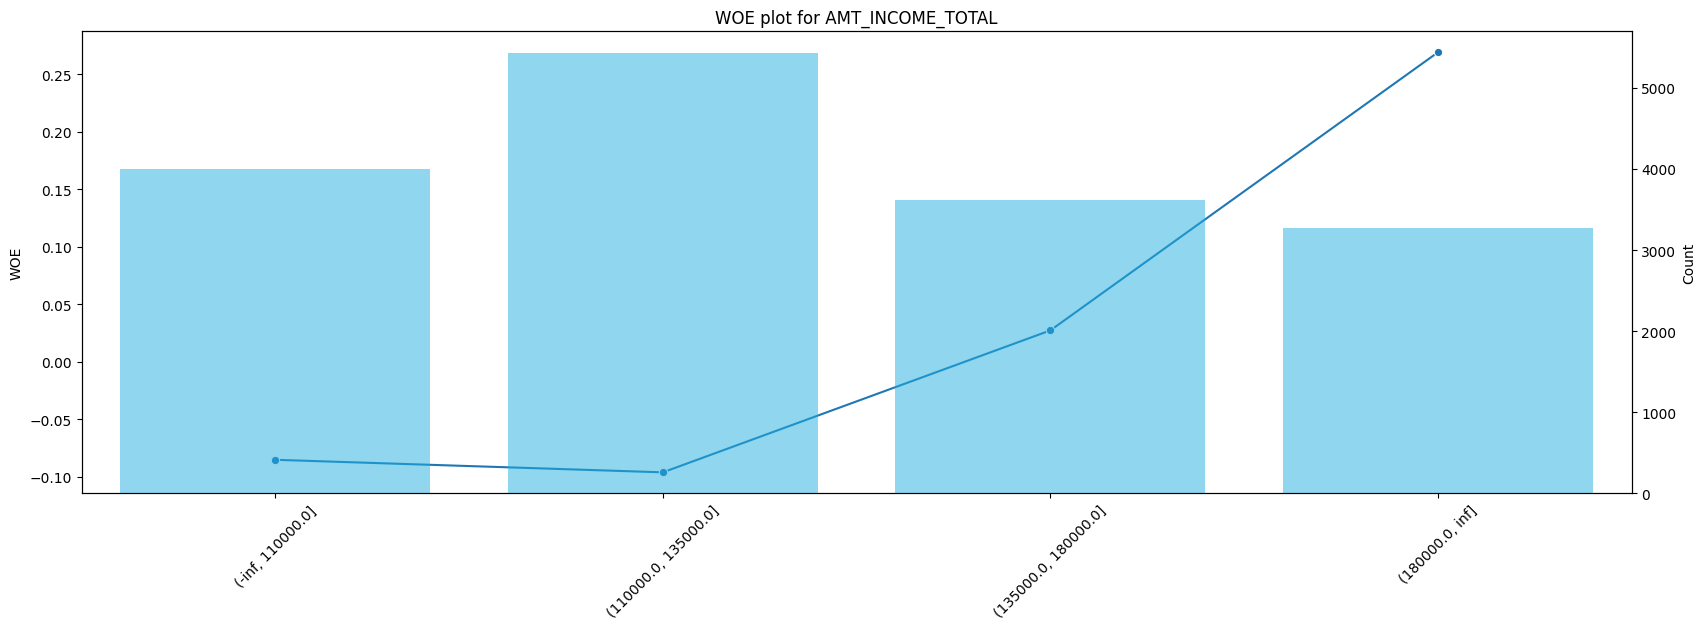

In [26]:
#Coarse classing for AMT_INCOME_TOTAL
bin_edges = [-np.inf, 110000, 135000, 180000, np.inf]
variable = 'AMT_INCOME_TOTAL'
encoded_data_working['Bin_Range'] = pd.cut(encoded_data[variable], bins = bin_edges, include_lowest= True)
encoded_data_working['Bin_Range'].value_counts().sort_index()

woe_iv(encoded_data_working, variable)
woe_iv_plot(encoded_data_working,variable)

IV for REGION_POPULATION_RELATIVE with 6 bins: 0.0306


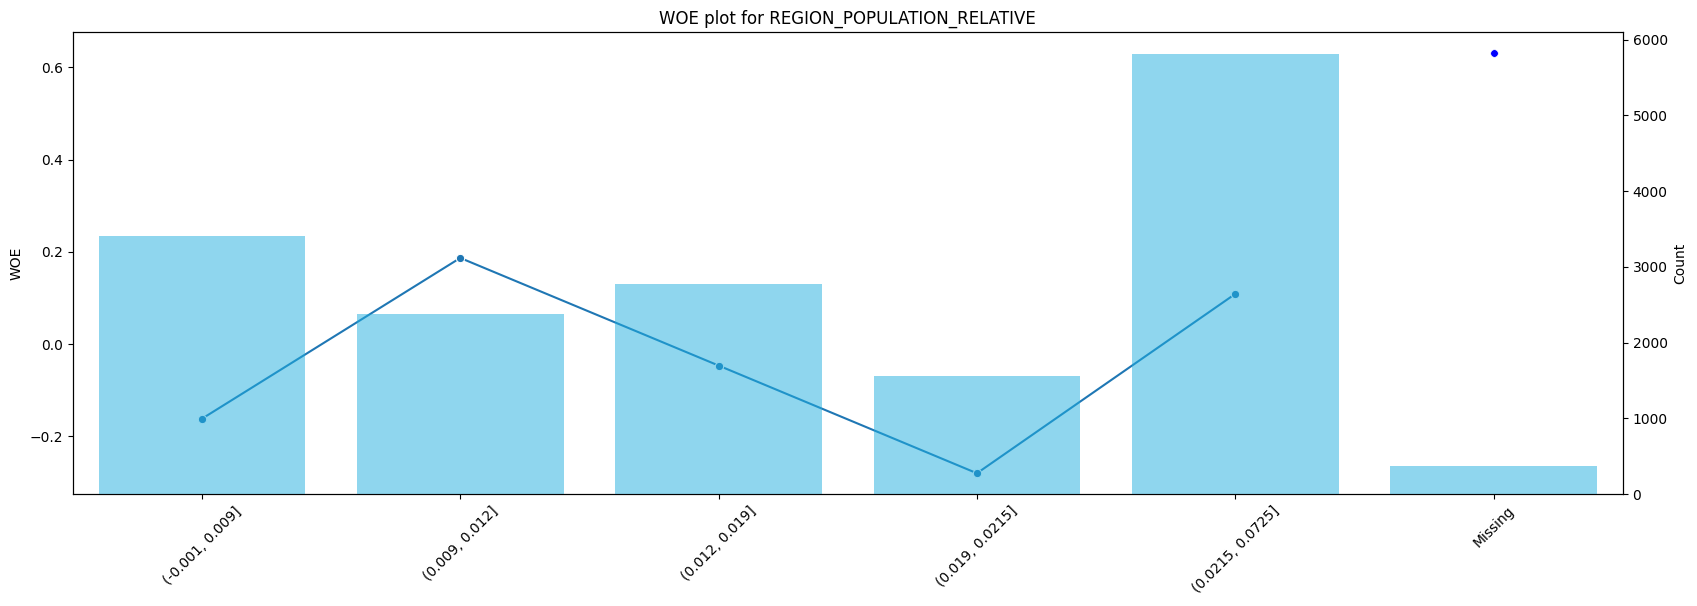

In [27]:
#Coarse classing for REGION_POPULATION_RELATIVE
bin_edges = [0, 0.00900, 0.0120, 0.0190, 0.0215, 0.0725]
variable = 'REGION_POPULATION_RELATIVE'
encoded_data_working['Bin_Range'] = pd.cut(encoded_data[variable], bins = bin_edges, include_lowest= True)
encoded_data_working['Bin_Range'].value_counts().sort_index()

woe_iv(encoded_data_working, variable)
woe_iv_plot(encoded_data_working,variable)

IV for AMT_GOODS_PRICE with 6 bins: 0.038


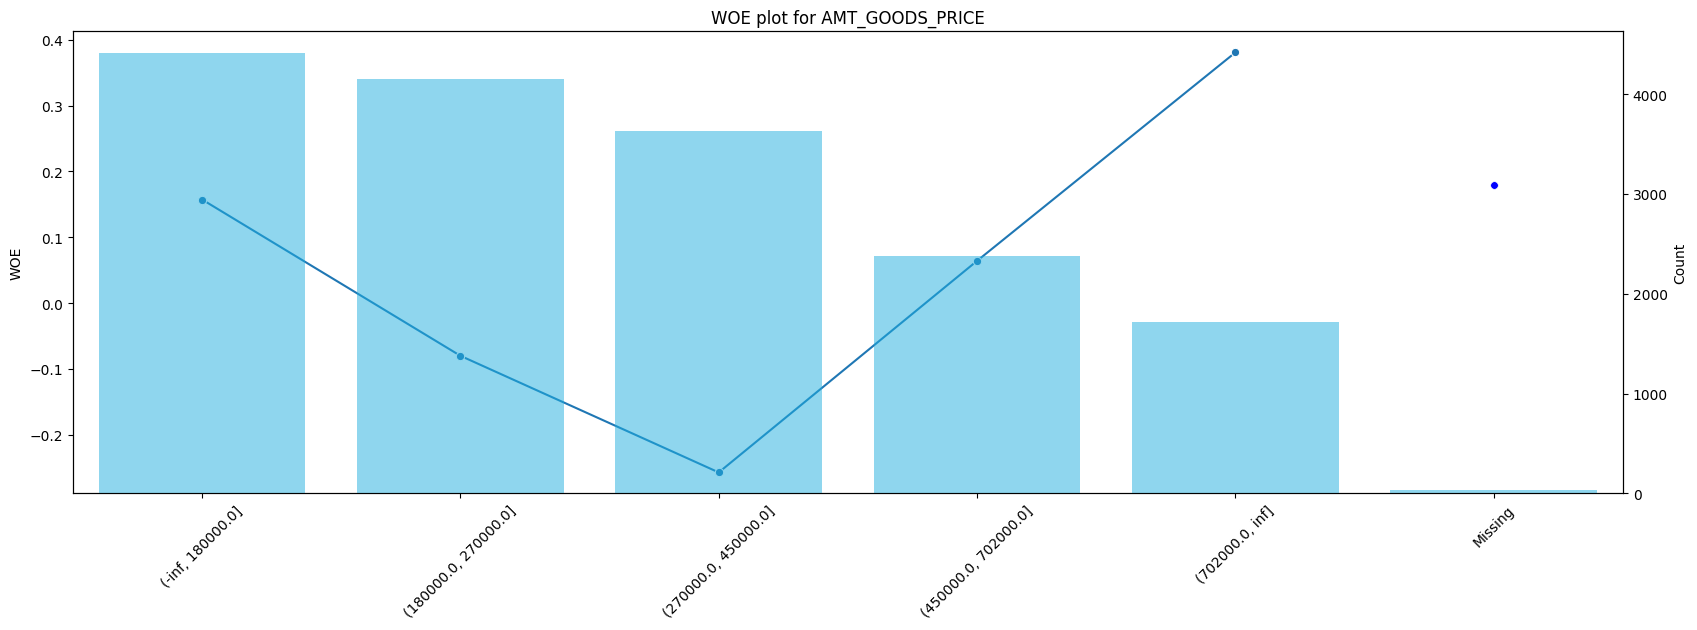

In [28]:
#Coarse classing for AMT_GOODS_PRICE
bin_edges = [-np.inf, 180000, 270000, 450000, 702000, np.inf]
variable = 'AMT_GOODS_PRICE'
encoded_data_working['Bin_Range'] = pd.cut(encoded_data[variable], bins = bin_edges, include_lowest= True)
encoded_data_working['Bin_Range'].value_counts().sort_index()

woe_iv(encoded_data_working, variable)
woe_iv_plot(encoded_data_working,variable)

##Step 9. Drop variables with IV Weak information value (< 0.02)

In [29]:
#Keep dataset with TARGET, the 8 variables selected from coarse classing
# List of columns to keep
columnskeep = ['TARGET',
    "EXT_SOURCE_1",
    "AVG_FREQ_CRED_APP",
    "REGION_RATING_CLIENT_W_CITY",
    "NUMACTIVE",
    "DAYS_ID_PUBLISH",
    "AMT_INCOME_TOTAL",
    "REGION_POPULATION_RELATIVE",
    "AMT_GOODS_PRICE"
]

# Subset the dataframe
encoded_data_working = encoded_data_working[columnskeep]
encoded_data_working.head()

,TARGET,EXT_SOURCE_1,AVG_FREQ_CRED_APP,REGION_RATING_CLIENT_W_CITY,NUMACTIVE,DAYS_ID_PUBLISH,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE
0,1,0.083037,874.0,2,2.0,2120,202500.0,0.018801,351000.0
1,0,0.115634,495.0,3,2.0,1368,157500.0,0.020713,247500.0
2,0,NaN,NaN,2,NaN,642,90000.0,0.009334,180000.0
3,0,NaN,562.0,1,0.0,586,180000.0,0.010006,1080000.0
4,0,0.479544,NaN,2,NaN,2104,85500.0,0.018029,135000.0


##Merge back with the 6 categorical variables

In [30]:
categorical_cols = [
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "ORGANIZATION_TYPE",
    "OCCUPATION_TYPE"
]

encoded_data_working = pd.concat([encoded_data_working, mapped_data[categorical_cols]],axis=1)

encoded_data_working.head()

,TARGET,EXT_SOURCE_1,AVG_FREQ_CRED_APP,REGION_RATING_CLIENT_W_CITY,NUMACTIVE,DAYS_ID_PUBLISH,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,ORGANIZATION_TYPE,OCCUPATION_TYPE
0,1,0.083037,874.0,2,2.0,2120,202500.0,0.018801,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,Business Entity Type 3,Laborers
1,0,0.115634,495.0,3,2.0,1368,157500.0,0.020713,247500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,Business Entity Type 2,Laborers
2,0,NaN,NaN,2,NaN,642,90000.0,0.009334,180000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,Self-employed,Sales staff
3,0,NaN,562.0,1,0.0,586,180000.0,0.010006,1080000.0,Working,Incomplete higher,Single / not married,With parents,Trade: type 2,Sales staff
4,0,0.479544,NaN,2,NaN,2104,85500.0,0.018029,135000.0,Working,Higher education,Married,House / apartment,Business Entity Type 1,NaN


##Tuning

## Step 10: Binning with custom bins from Coarse Classing

In [31]:
#For scorecard generation
import scorecardpy as sc
import warnings
import pprint
from sklearn import metrics

In [32]:
#Train, test split
print(encoded_data_working.columns)
train, test = sc.split_df(encoded_data_working, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)
print(train.columns)
print(test.columns)

Index(['TARGET', 'EXT_SOURCE_1', 'AVG_FREQ_CRED_APP',
       'REGION_RATING_CLIENT_W_CITY', 'NUMACTIVE', 'DAYS_ID_PUBLISH',
       'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE'],
      dtype='object')
(11422, 15)
(4896, 15)
Index(['TARGET', 'EXT_SOURCE_1', 'AVG_FREQ_CRED_APP',
       'REGION_RATING_CLIENT_W_CITY', 'NUMACTIVE', 'DAYS_ID_PUBLISH',
       'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE'],
      dtype='object')
Index(['TARGET', 'EXT_SOURCE_1', 'AVG_FREQ_CRED_APP',
       'REGION_RATING_CLIENT_W_CITY', 'NUMACTIVE', 'DAYS_ID_PUBLISH',
       'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', '

In [33]:
#Using own bins from coarse classing (some are WOE monotonic) (14 variables)
#Changed bin edges for tuning
custom_bins={
    'EXT_SOURCE_1': [0, 0.150, 0.250, 0.350, np.inf],
    'AVG_FREQ_CRED_APP': [0, 230, 420, 645, np.inf],
    'REGION_RATING_CLIENT_W_CITY': [0, 1, 2, 3],
    'AMT_GOODS_PRICE': [-np.inf, 180000, 450000, 702000, np.inf],
    'REGION_POPULATION_RELATIVE': [0, 0.00900, 0.0120, 0.0190, 0.0215, 0.0725], #cnt have -np.inf or np.inf as it removes missing category
    'AMT_INCOME_TOTAL': [-np.inf, 135000, 180000, np.inf],
    'NUMACTIVE': [0, 1,3,np.inf],
    'DAYS_ID_PUBLISH': [-np.inf, 1000, 1750, np.inf]
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y = 'TARGET', breaks_list=custom_bins)

for variables, bindetails in bins.items():
    print(variables, " : ")
    display(bindetails)
    print("--"*50)


[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no


Selection:  1


Binning on 11422 rows and 15 columns in 01:13:12
EXT_SOURCE_1  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_1,missing,5052,0.442304,4360,692,0.136975,0.176595,0.014752,0.157795,missing,True
1,EXT_SOURCE_1,"[-inf,0.15)",1174,0.102784,953,221,0.188245,0.555785,0.039054,0.157795,0.15,False
2,EXT_SOURCE_1,"[0.15,0.25)",1853,0.162231,1645,208,0.112250,-0.050721,0.000409,0.157795,0.25,False
3,EXT_SOURCE_1,"[0.25,0.35)",1398,0.122395,1284,114,0.081545,-0.404300,0.017125,0.157795,0.35,False
4,EXT_SOURCE_1,"[0.35,inf)",1945,0.170285,1839,106,0.054499,-0.836301,0.086454,0.157795,inf,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,2.0)",1192,0.104360,1097,95,0.079698,-0.429221,0.01630,0.04629,2.0,False
1,REGION_RATING_CLIENT_W_CITY,"[2.0,3.0)",8500,0.744178,7541,959,0.112824,-0.044982,0.00148,0.04629,3.0,False
2,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",1730,0.151462,1443,287,0.165896,0.402240,0.02851,0.04629,inf,False


----------------------------------------------------------------------------------------------------
DAYS_ID_PUBLISH  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_ID_PUBLISH,"[-inf,1000.0)",4012,0.351252,3469,543,0.135344,0.162725,0.009895,0.026597,1000.0,False
1,DAYS_ID_PUBLISH,"[1000.0,1750.0)",5213,0.456400,4610,603,0.115672,-0.016829,0.000128,0.026597,1750.0,False
2,DAYS_ID_PUBLISH,"[1750.0,inf)",2197,0.192348,2002,195,0.088757,-0.311666,0.016574,0.026597,inf,False


----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_POPULATION_RELATIVE,"[-inf,0.009)",2322,0.203292,2003,319,0.137382,0.180027,0.007056,0.025058,0.009,False
1,REGION_POPULATION_RELATIVE,"[0.009,0.012)",1680,0.147085,1515,165,0.098214,-0.199988,0.005448,0.025058,0.012,False
2,REGION_POPULATION_RELATIVE,"[0.012,0.019)",1932,0.169147,1691,241,0.124741,0.068958,0.000826,0.025058,0.019,False
3,REGION_POPULATION_RELATIVE,"[0.019,0.0215)",1087,0.095167,937,150,0.137994,0.185189,0.003502,0.025058,0.0215,False
4,REGION_POPULATION_RELATIVE,"[0.0215,0.0725)",4141,0.362546,3694,447,0.107945,-0.094670,0.003133,0.025058,0.0725,False
5,REGION_POPULATION_RELATIVE,"[0.0725,inf)",260,0.022763,241,19,0.073077,-0.523121,0.005094,0.025058,inf,False


----------------------------------------------------------------------------------------------------
NAME_HOUSING_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_HOUSING_TYPE,missing,2640,0.231133,2357,283,0.107197,-0.102461,0.002333,0.003135,missing,True
1,NAME_HOUSING_TYPE,"Co-op apartment%,%Rented apartment%,%Office ap...",2411,0.211084,2126,285,0.118208,0.007728,0.000013,0.003135,"Co-op apartment%,%Rented apartment%,%Office ap...",False
2,NAME_HOUSING_TYPE,"House / apartment%,%Municipal apartment",6371,0.557783,5598,773,0.121331,0.037351,0.000789,0.003135,"House / apartment%,%Municipal apartment",False


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,missing,24,0.002101,22,2,0.083333,-0.380658,0.000263,0.021243,missing,True
1,AMT_GOODS_PRICE,"[-inf,180000.0)",1359,0.118981,1222,137,0.100809,-0.171026,0.003259,0.021243,180000.0,False
2,AMT_GOODS_PRICE,"[180000.0,450000.0)",5989,0.524339,5257,732,0.122224,0.045702,0.001114,0.021243,450000.0,False
3,AMT_GOODS_PRICE,"[450000.0,702000.0)",2821,0.246980,2454,367,0.130096,0.117124,0.003543,0.021243,702000.0,False
4,AMT_GOODS_PRICE,"[702000.0,inf)",1229,0.107599,1126,103,0.083808,-0.374461,0.013064,0.021243,inf,False


----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,missing,2640,0.231133,2357,283,0.107197,-0.102461,0.002333,0.003125,missing,True
1,NAME_INCOME_TYPE,"Student%,%Unemployed%,%State servant%,%Pension...",3068,0.268604,2704,364,0.118644,0.011903,0.000038,0.003125,"Student%,%Unemployed%,%State servant%,%Pension...",False
2,NAME_INCOME_TYPE,Working,5714,0.500263,5020,694,0.121456,0.038524,0.000753,0.003125,Working,False


----------------------------------------------------------------------------------------------------
ORGANIZATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ORGANIZATION_TYPE,missing,2640,0.231133,2357,283,0.107197,-0.102461,0.002333,0.042618,missing,True
1,ORGANIZATION_TYPE,"Culture%,%Industry: type 6%,%Industry: type 13...",828,0.072492,767,61,0.073671,-0.514376,0.015737,0.042618,"Culture%,%Industry: type 6%,%Industry: type 13...",False
2,ORGANIZATION_TYPE,"Business Entity Type 2%,%Industry: type 5%,%Ot...",1044,0.091403,942,102,0.097701,-0.205796,0.003577,0.042618,"Business Entity Type 2%,%Industry: type 5%,%Ot...",False
3,ORGANIZATION_TYPE,"Military%,%University%,%Electricity%,%Self-emp...",1564,0.136929,1395,169,0.108056,-0.093514,0.001155,0.042618,"Military%,%University%,%Electricity%,%Self-emp...",False
4,ORGANIZATION_TYPE,"Industry: type 1%,%Transport: type 4%,%Postal%...",4224,0.369813,3679,545,0.129025,0.107626,0.004463,0.042618,"Industry: type 1%,%Transport: type 4%,%Postal%...",False
5,ORGANIZATION_TYPE,"Industry: type 9%,%Business Entity Type 1%,%Go...",1122,0.098231,941,181,0.161319,0.368791,0.015353,0.042618,"Industry: type 9%,%Business Entity Type 1%,%Go...",False


----------------------------------------------------------------------------------------------------
AVG_FREQ_CRED_APP  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AVG_FREQ_CRED_APP,missing,3046,0.266678,2686,360,0.118188,0.007533,0.000015,0.056977,missing,True
1,AVG_FREQ_CRED_APP,"[-inf,230.0)",1618,0.141656,1368,250,0.154512,0.317593,0.016111,0.056977,230.0,False
2,AVG_FREQ_CRED_APP,"[230.0,420.0)",2220,0.194362,1906,314,0.141441,0.213868,0.009642,0.056977,420.0,False
3,AVG_FREQ_CRED_APP,"[420.0,645.0)",2329,0.203905,2094,235,0.100902,-0.170009,0.005521,0.056977,645.0,False
4,AVG_FREQ_CRED_APP,"[645.0,inf)",2209,0.193399,2027,182,0.082390,-0.393069,0.025688,0.056977,inf,False


----------------------------------------------------------------------------------------------------
NUMACTIVE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUMACTIVE,missing,3046,0.266678,2686,360,0.118188,0.007533,0.000015,0.039959,missing,True
1,NUMACTIVE,"[-inf,1.0)",1230,0.107687,1137,93,0.075610,-0.486312,0.021123,0.039959,1.0,False
2,NUMACTIVE,"[1.0,3.0)",5194,0.454736,4605,589,0.113400,-0.039235,0.000690,0.039959,3.0,False
3,NUMACTIVE,"[3.0,inf)",1952,0.170898,1653,299,0.153176,0.307333,0.018131,0.039959,inf,False


----------------------------------------------------------------------------------------------------
NAME_FAMILY_STATUS  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_FAMILY_STATUS,missing,2640,0.231133,2357,283,0.107197,-0.102461,0.002333,0.003483,missing,True
1,NAME_FAMILY_STATUS,"Widow%,%Civil marriage",1245,0.109000,1102,143,0.114859,-0.024800,0.000066,0.003483,"Widow%,%Civil marriage",False
2,NAME_FAMILY_STATUS,Married,3165,0.277097,2786,379,0.119747,0.022411,0.000140,0.003483,Married,False
3,NAME_FAMILY_STATUS,"Single / not married%,%Separated",4372,0.382770,3836,536,0.122598,0.049186,0.000944,0.003483,"Single / not married%,%Separated",False


----------------------------------------------------------------------------------------------------
AMT_INCOME_TOTAL  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_INCOME_TOTAL,"[-inf,135000.0)",4972,0.435300,4320,652,0.131134,0.126271,0.007283,0.025622,135000.0,False
1,AMT_INCOME_TOTAL,"[135000.0,180000.0)",3239,0.283576,2847,392,0.121025,0.034478,0.000342,0.025622,180000.0,False
2,AMT_INCOME_TOTAL,"[180000.0,inf)",3211,0.281124,2914,297,0.092495,-0.266313,0.017998,0.025622,inf,False


----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,missing,4645,0.406671,4094,551,0.118622,0.011694,0.000056,0.006072,missing,True
1,OCCUPATION_TYPE,"Low-skill Laborers%,%Waiters/barmen staff%,%Pr...",675,0.059096,613,62,0.091852,-0.273994,0.003993,0.006072,"Low-skill Laborers%,%Waiters/barmen staff%,%Pr...",False
2,OCCUPATION_TYPE,"Accountants%,%Security staff%,%Medicine staff%...",2849,0.249431,2525,324,0.113724,-0.036016,0.000319,0.006072,"Accountants%,%Security staff%,%Medicine staff%...",False
3,OCCUPATION_TYPE,"Secretaries%,%Laborers",2475,0.216687,2174,301,0.121616,0.040023,0.000352,0.006072,"Secretaries%,%Laborers",False
4,OCCUPATION_TYPE,"Drivers%,%IT staff%,%HR staff%,%Cleaning staff",778,0.068114,675,103,0.132391,0.137253,0.001352,0.006072,"Drivers%,%IT staff%,%HR staff%,%Cleaning staff",False


----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_EDUCATION_TYPE,missing,2640,0.231133,2357,283,0.107197,-0.102461,0.002333,0.003728,missing,True
1,NAME_EDUCATION_TYPE,"Academic degree%,%Incomplete higher",1165,0.101996,1034,131,0.112446,-0.048756,0.000238,0.003728,"Academic degree%,%Incomplete higher",False
2,NAME_EDUCATION_TYPE,Secondary / secondary special,5795,0.507354,5092,703,0.121311,0.037168,0.000711,0.003728,Secondary / secondary special,False
3,NAME_EDUCATION_TYPE,"Higher education%,%Lower secondary",1822,0.159517,1598,224,0.122942,0.052375,0.000446,0.003728,"Higher education%,%Lower secondary",False


----------------------------------------------------------------------------------------------------


##Step 11: Remove categorical variables with IV < 0.02

In [34]:
selected_df = encoded_data_working.copy()
selected_df = selected_df.drop(['NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS'], axis=1)

In [35]:
#Train, test split
print(selected_df.columns)
train, test = sc.split_df(selected_df, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)
print(train.columns)
print(test.columns)

Index(['TARGET', 'EXT_SOURCE_1', 'AVG_FREQ_CRED_APP',
       'REGION_RATING_CLIENT_W_CITY', 'NUMACTIVE', 'DAYS_ID_PUBLISH',
       'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'ORGANIZATION_TYPE'],
      dtype='object')
(11422, 10)
(4896, 10)
Index(['TARGET', 'EXT_SOURCE_1', 'AVG_FREQ_CRED_APP',
       'REGION_RATING_CLIENT_W_CITY', 'NUMACTIVE', 'DAYS_ID_PUBLISH',
       'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'ORGANIZATION_TYPE'],
      dtype='object')
Index(['TARGET', 'EXT_SOURCE_1', 'AVG_FREQ_CRED_APP',
       'REGION_RATING_CLIENT_W_CITY', 'NUMACTIVE', 'DAYS_ID_PUBLISH',
       'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'ORGANIZATION_TYPE'],
      dtype='object')


In [36]:
#Using own bins from coarse classing (some are WOE monotonic) (9 variables)
#changed bin edges for tuning
custom_bins={
    'EXT_SOURCE_1': [0, 0.150, 0.250, 0.350, np.inf],
    'AVG_FREQ_CRED_APP': [0, 230, 420, 645, np.inf],
    'REGION_RATING_CLIENT_W_CITY': [0, 1, 2, 3],
    'AMT_GOODS_PRICE': [-np.inf, 180000, 450000, 702000, np.inf],
    'REGION_POPULATION_RELATIVE': [0, 0.00900, 0.0120, 0.0190, 0.0215, 0.0725], #cnt have -np.inf or np.inf as it removes missing category
    'AMT_INCOME_TOTAL': [-np.inf, 135000, 180000, np.inf],
    'NUMACTIVE': [0, 1,3,np.inf],
    'DAYS_ID_PUBLISH': [-np.inf, 1000, 1750, np.inf]
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y = 'TARGET', breaks_list=custom_bins)

for variables, bindetails in bins.items():
    print(variables, " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no


Selection:  1


EXT_SOURCE_1  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_1,missing,5052,0.442304,4360,692,0.136975,0.176595,0.014752,0.157795,missing,True
1,EXT_SOURCE_1,"[-inf,0.15)",1174,0.102784,953,221,0.188245,0.555785,0.039054,0.157795,0.15,False
2,EXT_SOURCE_1,"[0.15,0.25)",1853,0.162231,1645,208,0.112250,-0.050721,0.000409,0.157795,0.25,False
3,EXT_SOURCE_1,"[0.25,0.35)",1398,0.122395,1284,114,0.081545,-0.404300,0.017125,0.157795,0.35,False
4,EXT_SOURCE_1,"[0.35,inf)",1945,0.170285,1839,106,0.054499,-0.836301,0.086454,0.157795,inf,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,2.0)",1192,0.104360,1097,95,0.079698,-0.429221,0.01630,0.04629,2.0,False
1,REGION_RATING_CLIENT_W_CITY,"[2.0,3.0)",8500,0.744178,7541,959,0.112824,-0.044982,0.00148,0.04629,3.0,False
2,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",1730,0.151462,1443,287,0.165896,0.402240,0.02851,0.04629,inf,False


----------------------------------------------------------------------------------------------------
DAYS_ID_PUBLISH  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_ID_PUBLISH,"[-inf,1000.0)",4012,0.351252,3469,543,0.135344,0.162725,0.009895,0.026597,1000.0,False
1,DAYS_ID_PUBLISH,"[1000.0,1750.0)",5213,0.456400,4610,603,0.115672,-0.016829,0.000128,0.026597,1750.0,False
2,DAYS_ID_PUBLISH,"[1750.0,inf)",2197,0.192348,2002,195,0.088757,-0.311666,0.016574,0.026597,inf,False


----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_POPULATION_RELATIVE,"[-inf,0.009)",2322,0.203292,2003,319,0.137382,0.180027,0.007056,0.025058,0.009,False
1,REGION_POPULATION_RELATIVE,"[0.009,0.012)",1680,0.147085,1515,165,0.098214,-0.199988,0.005448,0.025058,0.012,False
2,REGION_POPULATION_RELATIVE,"[0.012,0.019)",1932,0.169147,1691,241,0.124741,0.068958,0.000826,0.025058,0.019,False
3,REGION_POPULATION_RELATIVE,"[0.019,0.0215)",1087,0.095167,937,150,0.137994,0.185189,0.003502,0.025058,0.0215,False
4,REGION_POPULATION_RELATIVE,"[0.0215,0.0725)",4141,0.362546,3694,447,0.107945,-0.094670,0.003133,0.025058,0.0725,False
5,REGION_POPULATION_RELATIVE,"[0.0725,inf)",260,0.022763,241,19,0.073077,-0.523121,0.005094,0.025058,inf,False


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,missing,24,0.002101,22,2,0.083333,-0.380658,0.000263,0.021243,missing,True
1,AMT_GOODS_PRICE,"[-inf,180000.0)",1359,0.118981,1222,137,0.100809,-0.171026,0.003259,0.021243,180000.0,False
2,AMT_GOODS_PRICE,"[180000.0,450000.0)",5989,0.524339,5257,732,0.122224,0.045702,0.001114,0.021243,450000.0,False
3,AMT_GOODS_PRICE,"[450000.0,702000.0)",2821,0.246980,2454,367,0.130096,0.117124,0.003543,0.021243,702000.0,False
4,AMT_GOODS_PRICE,"[702000.0,inf)",1229,0.107599,1126,103,0.083808,-0.374461,0.013064,0.021243,inf,False


----------------------------------------------------------------------------------------------------
ORGANIZATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ORGANIZATION_TYPE,missing,2640,0.231133,2357,283,0.107197,-0.102461,0.002333,0.042618,missing,True
1,ORGANIZATION_TYPE,"Culture%,%Industry: type 6%,%Industry: type 13...",828,0.072492,767,61,0.073671,-0.514376,0.015737,0.042618,"Culture%,%Industry: type 6%,%Industry: type 13...",False
2,ORGANIZATION_TYPE,"Business Entity Type 2%,%Industry: type 5%,%Ot...",1044,0.091403,942,102,0.097701,-0.205796,0.003577,0.042618,"Business Entity Type 2%,%Industry: type 5%,%Ot...",False
3,ORGANIZATION_TYPE,"Military%,%University%,%Electricity%,%Self-emp...",1564,0.136929,1395,169,0.108056,-0.093514,0.001155,0.042618,"Military%,%University%,%Electricity%,%Self-emp...",False
4,ORGANIZATION_TYPE,"Industry: type 1%,%Transport: type 4%,%Postal%...",4224,0.369813,3679,545,0.129025,0.107626,0.004463,0.042618,"Industry: type 1%,%Transport: type 4%,%Postal%...",False
5,ORGANIZATION_TYPE,"Industry: type 9%,%Business Entity Type 1%,%Go...",1122,0.098231,941,181,0.161319,0.368791,0.015353,0.042618,"Industry: type 9%,%Business Entity Type 1%,%Go...",False


----------------------------------------------------------------------------------------------------
AVG_FREQ_CRED_APP  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AVG_FREQ_CRED_APP,missing,3046,0.266678,2686,360,0.118188,0.007533,0.000015,0.056977,missing,True
1,AVG_FREQ_CRED_APP,"[-inf,230.0)",1618,0.141656,1368,250,0.154512,0.317593,0.016111,0.056977,230.0,False
2,AVG_FREQ_CRED_APP,"[230.0,420.0)",2220,0.194362,1906,314,0.141441,0.213868,0.009642,0.056977,420.0,False
3,AVG_FREQ_CRED_APP,"[420.0,645.0)",2329,0.203905,2094,235,0.100902,-0.170009,0.005521,0.056977,645.0,False
4,AVG_FREQ_CRED_APP,"[645.0,inf)",2209,0.193399,2027,182,0.082390,-0.393069,0.025688,0.056977,inf,False


----------------------------------------------------------------------------------------------------
NUMACTIVE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUMACTIVE,missing,3046,0.266678,2686,360,0.118188,0.007533,0.000015,0.039959,missing,True
1,NUMACTIVE,"[-inf,1.0)",1230,0.107687,1137,93,0.075610,-0.486312,0.021123,0.039959,1.0,False
2,NUMACTIVE,"[1.0,3.0)",5194,0.454736,4605,589,0.113400,-0.039235,0.000690,0.039959,3.0,False
3,NUMACTIVE,"[3.0,inf)",1952,0.170898,1653,299,0.153176,0.307333,0.018131,0.039959,inf,False


----------------------------------------------------------------------------------------------------
AMT_INCOME_TOTAL  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_INCOME_TOTAL,"[-inf,135000.0)",4972,0.435300,4320,652,0.131134,0.126271,0.007283,0.025622,135000.0,False
1,AMT_INCOME_TOTAL,"[135000.0,180000.0)",3239,0.283576,2847,392,0.121025,0.034478,0.000342,0.025622,180000.0,False
2,AMT_INCOME_TOTAL,"[180000.0,inf)",3211,0.281124,2914,297,0.092495,-0.266313,0.017998,0.025622,inf,False


----------------------------------------------------------------------------------------------------


##Step 12: WOE Encoding

In [37]:
#convert to woe values
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_woe = sc.woebin_ply(train, bins)
    test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,TARGET,EXT_SOURCE_1_woe,DAYS_ID_PUBLISH_woe,REGION_RATING_CLIENT_W_CITY_woe,REGION_POPULATION_RELATIVE_woe,AMT_GOODS_PRICE_woe,ORGANIZATION_TYPE_woe,AVG_FREQ_CRED_APP_woe,NUMACTIVE_woe,AMT_INCOME_TOTAL_woe
0,1,0.555785,-0.311666,-0.044982,0.068958,0.045702,0.107626,-0.393069,-0.039235,-0.266313
1,0,0.555785,-0.016829,0.402240,0.185189,0.045702,-0.205796,-0.170009,-0.039235,0.034478
4,0,-0.836301,-0.311666,-0.044982,0.068958,-0.171026,0.368791,0.007533,0.007533,0.126271
5,0,-0.836301,-0.311666,0.402240,0.180027,0.045702,-0.093514,0.007533,0.007533,0.126271
7,0,0.555785,-0.016829,-0.044982,-0.094670,0.045702,-0.205796,0.317593,-0.039235,0.034478
...,...,...,...,...,...,...,...,...,...,...
16311,0,0.176595,0.162725,0.402240,0.180027,0.045702,-0.102461,0.213868,-0.039235,0.034478
16313,0,0.555785,0.162725,-0.044982,-0.094670,0.045702,-0.102461,0.007533,0.007533,0.126271
16314,0,-0.050721,-0.311666,-0.044982,0.180027,0.045702,-0.102461,0.317593,-0.039235,0.034478
16315,0,0.176595,-0.016829,-0.044982,0.185189,0.117124,-0.102461,0.213868,0.307333,0.126271


##Step 13: Logistic Regression Model Training

In [38]:
# create the X, y parts of data for train and test
# Fill NaN values with the mean of each column

y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

# Make copies of the original data (before any imputation)
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# Fill NaN values with the mean for logistic regression (temporarily)
X_train_temp = X_train.fillna(X_train.mean())
X_test_temp = X_test.fillna(X_test.mean())

# create a logistic regression model object
lr = LogisticRegression()
lr.fit(X_train_temp, y_train)

# After training, revert X_train and X_test to their original form with NaN values
X_train = X_train_original
X_test = X_test_original
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )


intercept                         -2.017067
EXT_SOURCE_1_woe                   0.934891
DAYS_ID_PUBLISH_woe                0.626848
REGION_RATING_CLIENT_W_CITY_woe    0.658772
REGION_POPULATION_RELATIVE_woe     0.420739
AMT_GOODS_PRICE_woe                0.730522
ORGANIZATION_TYPE_woe              0.988498
AVG_FREQ_CRED_APP_woe              0.641250
NUMACTIVE_woe                      1.031593
AMT_INCOME_TOTAL_woe               0.663655
dtype: float64

##Step 14: Scorecard generation

In [39]:
# generate a card from the model and bins. The scores will be based on probability of default from the model
# bins = bins created from sc.woebin
# lr = fitted logistic regression model
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'AMT_GOODS_PRICE':            variable                  bin  points
17  AMT_GOODS_PRICE              missing    72.0
18  AMT_GOODS_PRICE      [-inf,180000.0)    67.0
19  AMT_GOODS_PRICE  [180000.0,450000.0)    63.0
20  AMT_GOODS_PRICE  [450000.0,702000.0)    61.0
21  AMT_GOODS_PRICE       [702000.0,inf)    71.0,
 'AMT_INCOME_TOTAL':             variable                  bin  points
37  AMT_INCOME_TOTAL      [-inf,135000.0)    61.0
38  AMT_INCOME_TOTAL  [135000.0,180000.0)    63.0
39  AMT_INCOME_TOTAL       [180000.0,inf)    69.0,
 'AVG_FREQ_CRED_APP':              variable            bin  points
28  AVG_FREQ_CRED_APP        missing    63.0
29  AVG_FREQ_CRED_APP   [-inf,230.0)    58.0
30  AVG_FREQ_CRED_APP  [230.0,420.0)    60.0
31  AVG_FREQ_CRED_APP  [420.0,645.0)    67.0
32  AVG_FREQ_CRED_APP    [645.0,inf)    71.0,
 'DAYS_ID_PUBLISH':            variable              bin  points
8   DAYS_ID_PUBLISH    [-inf,1000.0)    61.0
9   DAYS_ID_PUBLISH  [1000.0,1750.0)    64.0
10  DAYS_ID_PUB

##Test Scorecard

In [40]:
#Test values
col = ['EXT_SOURCE_1','AVG_FREQ_CRED_APP','REGION_RATING_CLIENT_W_CITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE','AMT_INCOME_TOTAL','NUMACTIVE','DAYS_ID_PUBLISH', 'ORGANIZATION_TYPE']
val = [[0.083037, 874, 2, 351000, 0.018801, 202500, 2, 2120, 'Business Entity Type 3']]
new_appl = pd.DataFrame(val, columns = col)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score = False).transpose()
new_appl_score.index = new_appl_score.index.str.replace('_points', '')

summary = pd.concat([new_appl.transpose(), new_appl_score], axis=1)
summary.columns = ['App Value', 'Points']
print(summary)

                                          App Value  Points
EXT_SOURCE_1                               0.083037    49.0
AVG_FREQ_CRED_APP                               874    71.0
REGION_RATING_CLIENT_W_CITY                       2    64.0
AMT_GOODS_PRICE                              351000    63.0
REGION_POPULATION_RELATIVE                 0.018801    63.0
AMT_INCOME_TOTAL                             202500    69.0
NUMACTIVE                                         2    65.0
DAYS_ID_PUBLISH                                2120    69.0
ORGANIZATION_TYPE            Business Entity Type 3    60.0
score                                           NaN   573.0


##Step 15: Model Evaluation

In [41]:
#score all data
# credit score for samples in test and train
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_score = sc.scorecard_ply(train, card)
    test_score = sc.scorecard_ply(test, card)

In [42]:
#calculate percentage correctly classified
cutoff=600

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[1225 8856]
 [  41 1300]]
PCC measures:
              precision    recall  f1-score   support

           0       0.97      0.12      0.22     10081
           1       0.13      0.97      0.23      1341

    accuracy                           0.22     11422
   macro avg       0.55      0.55      0.22     11422
weighted avg       0.87      0.22      0.22     11422

*** Test Data Performance ***
Confusion matrix:
[[ 489 3832]
 [  19  556]]
PCC measures:
              precision    recall  f1-score   support

           0       0.96      0.11      0.20      4321
           1       0.13      0.97      0.22       575

    accuracy                           0.21      4896
   macro avg       0.54      0.54      0.21      4896
weighted avg       0.86      0.21      0.21      4896



###Distribution of scores

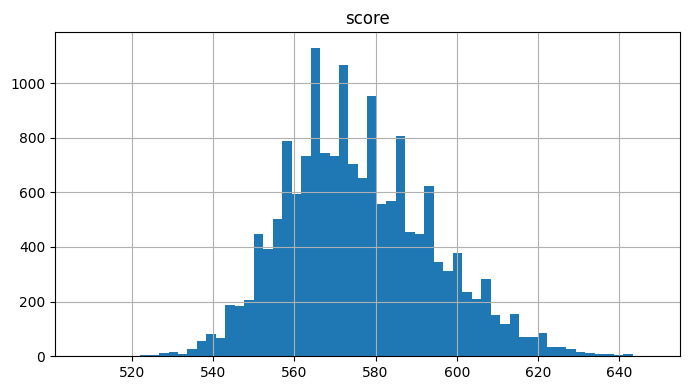

In [43]:
#Examine the distribution of scores
# combine scores for train and test data to assess distribution for entire population
combined_score = pd.concat([train_score, test_score], ignore_index=True)

# plot distribution of scores on copmbined data
combined_score.hist(figsize = (7, 4), bins = 60)
plt.tight_layout()

###Approval rate

In [44]:
#how many were approved
cutoff = 600

approval_count = train_score[train_score["score"]>cutoff].count()['score']
approval_rate = approval_count/train_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

Cutoff score of 600: 1,166 applications approved (10.2%)


###Expect defaults

In [45]:
#expected number of defaults
odds_at_cutoff = 20

default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

Cutoff score of 600: 56 defaults expected


##Change cutoff score and test again

In [46]:
#changing cutoff to 580
cutoff = 580
approval_count = train_score[train_score["score"]>cutoff].count()['score']
approval_rate = approval_count/train_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

odds_at_cutoff = 10
default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

Cutoff score of 580: 4,276 applications approved (37.4%)
Cutoff score of 580: 389 defaults expected
*** Training Data Performance ***
Confusion matrix:
[[4213 5868]
 [ 282 1059]]
PCC measures:
              precision    recall  f1-score   support

           0       0.94      0.42      0.58     10081
           1       0.15      0.79      0.26      1341

    accuracy                           0.46     11422
   macro avg       0.55      0.60      0.42     11422
weighted avg       0.85      0.46      0.54     11422

*** Test Data Performance ***
Confusion matrix:
[[1699 2622]
 [ 133  442]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.39      0.55      4321
           1       0.14      0.77      0.24       575

    accuracy                           0.44      4896
   macro avg       0.54      0.58      0.40      4896
weighted avg       0.84      0.44      0.52      4896



In [47]:
#changing cutoff to 560
cutoff = 560
approval_count = train_score[train_score["score"]>cutoff].count()['score']
approval_rate = approval_count/train_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

odds_at_cutoff = 5
default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

Cutoff score of 560: 9,155 applications approved (80.2%)
Cutoff score of 560: 1526 defaults expected
*** Training Data Performance ***
Confusion matrix:
[[8459 1622]
 [ 900  441]]
PCC measures:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     10081
           1       0.21      0.33      0.26      1341

    accuracy                           0.78     11422
   macro avg       0.56      0.58      0.56     11422
weighted avg       0.82      0.78      0.80     11422

*** Test Data Performance ***
Confusion matrix:
[[3563  758]
 [ 404  171]]
PCC measures:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      4321
           1       0.18      0.30      0.23       575

    accuracy                           0.76      4896
   macro avg       0.54      0.56      0.54      4896
weighted avg       0.81      0.76      0.79      4896

